# ML2 (CSCI 4052U) Exam: RL

Installs:
- pip install gymnasium
- pip install swig
- pip install "gymnasium[box2d]"

In [5]:
import gymnasium as gym
import numpy as np
import time
import math
from matplotlib import pyplot as plt

Lunar Lander Page: https://gymnasium.farama.org/environments/box2d/lunar_lander/

64 possible states, 4 actions (left, down, right, up)

In [6]:
def visualize_best_result(episodes, q, slippery=True):
    print("")
    print("Optimal Result (as determined by Q-Values:")

    action_array = ["Left", "Down", "Right", "Up"]
    actions_taken = 0
    
    env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=slippery, render_mode="human")

    for _ in range(episodes):
        state, info = env.reset()

        while True:
            action = np.argmax(q[state,:])

            new_state, reward, terminated, truncated, info = env.step(action)

            state = new_state

            if _ == 0:
                actions_taken += 1
                print("Action taken:", action_array[action], " | Reward Given:", reward, " | Terminated:", terminated, " | Actions Taken:", actions_taken)

            if terminated or truncated:
                break

    env.close()

In [7]:



# Runs the requested amount of episodes using Q-Learning
# episodes = # of episodes to run through
# learning_rate = 0 to 1, closer to 1 results in newer episodes taking higher priority in the q-values, changing the values faster
# discount_factor = 0 to 1, closer to 1 values future rewards highly, closer to 0 focuses on immediate rewards more
# epsilon = 0 to 1, chance of taking a random action (1 is always random, 0 is always optimal action as per q values)
# epsilon_change = how much to lower epsilon by per episode (over time max q-value should take priority and exploration minimized)
# slippery = If False, the action requested is always followed through on. If True, the action requested is followed through on 1/3 of the time,
#            and the two perpendicular actions are taken 1/3 of the time each (ex. request=left (1/3 chance), 1/3 chance of slipping up, 1/3 of down)
# render = None for no visualization, "Human" to see visualization

def run_episodes(episodes, learning_rate=0.05, discount_factor=0.95, epsilon=1, epsilon_change=0.01, slippery=True, render=None):
    env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=slippery, render_mode=render)

    # 64 states (0 to 63) and 4 actions (0 = left, 1 = down, 2 = right, 3 = up)
    q = np.zeros((env.observation_space.n, env.action_space.n)) # q-value storage
    rng = np.random.default_rng() # random number from 0 to 1 (to determine if random action should be taken)
    completions = np.full(episodes,False)
    ep_lengths = np.zeros(episodes)
    ep_epsilons = np.zeros(episodes)
    checkpoints = math.floor(episodes/10) # Print statement at 10% completion intervals

    print("Ran using the following settings:")
    print("Episodes:", episodes)
    print("Learning Rate:", learning_rate)
    print("Discount Factor:", discount_factor)
    print("Initial Epsilon:", epsilon)
    print("Epsilon Decay (per episode):", epsilon_change)
    print("Slippery:", slippery)
    print("")

    for _ in range(episodes):
        state, info = env.reset()
        
        if (_+1)%checkpoints==0:
            print("Ep", _, " , Epsi:", round(epsilon,3), " | Comp:", completions.sum(), " | Success Rate:", round(completions.sum()/_,3)*100,"%")
          

        while True:

            if rng.random() < epsilon:
                action = env.action_space.sample() # Random action
            else:
                action = np.argmax(q[state,:])

            # new_state: After taking the action calculated above, what position are we now in? (0-63)
            # reward: The reward for taking that action (reach goal = +1, reach hole/frozen = 0)
            # terminated: True if the player moves into a hole OR the player reaches the goal
            # truncation: True if the limit (length of episode) is reached, this is 200 for 8x8 env
            # info: number from 0 to 1 with odds of taking the action requested (1/3 if is_slippery, 1 otherwise)
            new_state, reward, terminated, truncated, info = env.step(action)

            if reward == 1:
                completions[_] = True

            q[state,action] = q[state,action] + learning_rate * (reward + discount_factor * max(q[new_state,:]) -q[state,action])

            state = new_state
            ep_lengths[_] += 1

            if terminated or truncated:
                break

        ep_epsilons[_] = epsilon
        epsilon -= epsilon_change # Lower Epsilon by specified amount
        if epsilon < 0:
            epsilon = 0

    time.sleep(0.5)
    env.close()
    
    print("\nSimple Breakdown:")
    print("Episodes:", episodes)
    print("Successful Episodes:", completions.sum())
    print("Failed Episodes:", (episodes-completions.sum()))
    print("Success Rate:", round(((completions.sum())/(episodes))*100,3), "%")
    print("Success Episode Array:", np.convolve(completions, np.ones(100), 'valid'))

    print("")
    print("Q-Values:")
    print(q)

    # np.convolve will compute the rolling mean for 100 episodes

    fig, axs = plt.subplots(1, 2, figsize=(20, 8))

    axs[0].plot(np.convolve(completions, np.ones(100), 'valid'))
    axs[0].set_title("Successful Episodes")
    axs[0].set_xlabel("Episode")
    axs[0].set_ylabel("# of Successful Episodes Out of Past 100")

    ax2 = axs[0].twinx()
    ax2.plot(np.convolve(ep_epsilons, np.ones(100), 'valid') / 100, color='red')
    ax2.set_ylabel("Epsilon (Rolling 100 Episode Mean)")
    ax2.set_ylim([0, 1])
    

    axs[1].plot(np.convolve(ep_lengths, np.ones(100), 'valid') / 100)
    axs[1].set_title("Episode Lengths")
    axs[1].set_xlabel("Episode")
    axs[1].set_ylabel("Length")

    visualize_best_result(3, q, slippery=slippery)

    

Ran using the following settings:
Episodes: 1110
Learning Rate: 0.001
Discount Factor: 0.95
Initial Epsilon: 1
Epsilon Decay (per episode): 0.001
Slippery: False

Ep 110  , Epsi: 0.89  | Comp: 0  | Success Rate: 0.0 %
Ep 221  , Epsi: 0.779  | Comp: 0  | Success Rate: 0.0 %
Ep 332  , Epsi: 0.668  | Comp: 0  | Success Rate: 0.0 %
Ep 443  , Epsi: 0.557  | Comp: 0  | Success Rate: 0.0 %
Ep 554  , Epsi: 0.446  | Comp: 0  | Success Rate: 0.0 %
Ep 665  , Epsi: 0.335  | Comp: 0  | Success Rate: 0.0 %
Ep 776  , Epsi: 0.224  | Comp: 0  | Success Rate: 0.0 %
Ep 887  , Epsi: 0.113  | Comp: 0  | Success Rate: 0.0 %
Ep 998  , Epsi: 0.002  | Comp: 0  | Success Rate: 0.0 %
Ep 1109  , Epsi: 0  | Comp: 0  | Success Rate: 0.0 %

Simple Breakdown:
Episodes: 1110
Successful Episodes: 0
Failed Episodes: 1110
Success Rate: 0.0 %
Success Episode Array: [0. 0. 0. ... 0. 0. 0.]


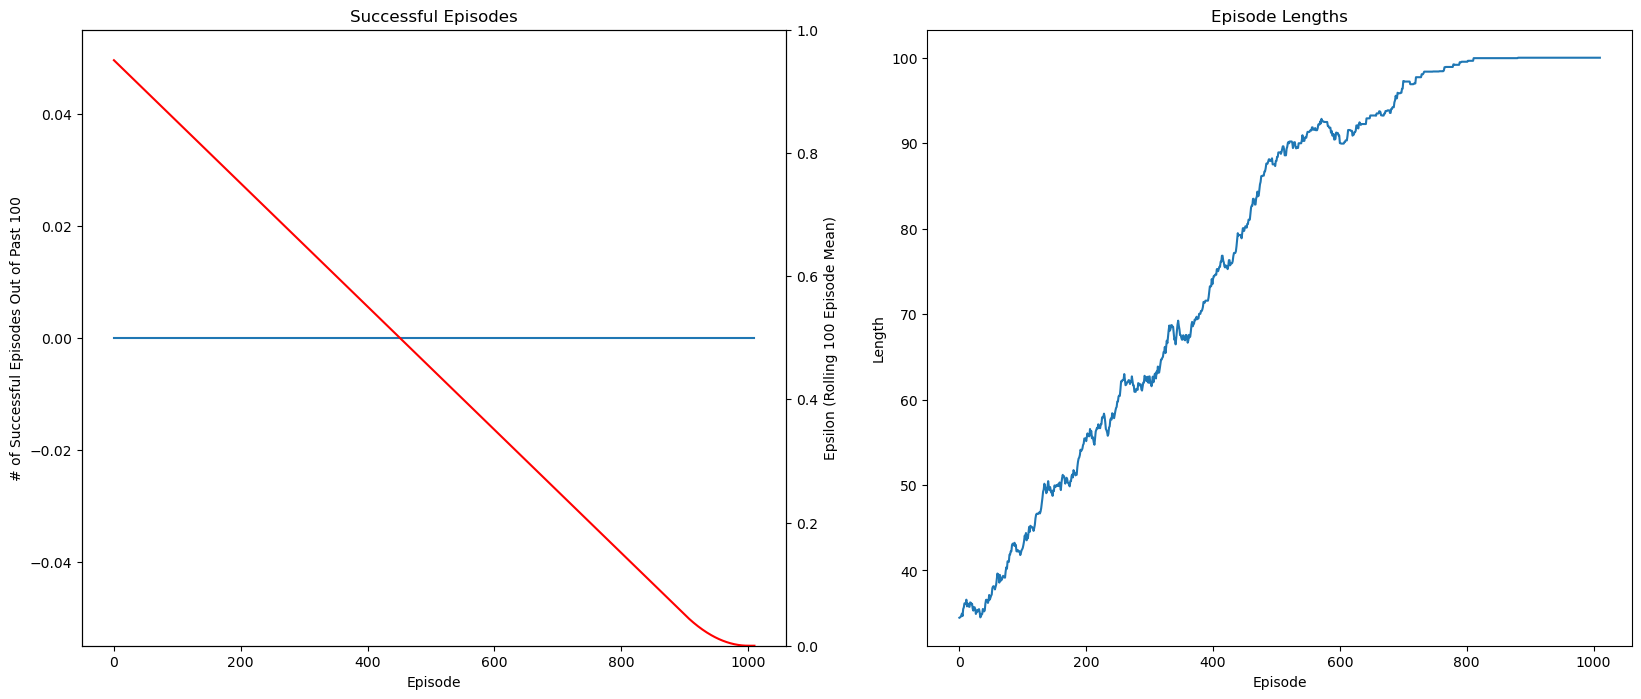

In [4]:
# render="Human" to visualize
# Slippery = False
run_episodes(1110, epsilon_change=0.001, slippery=False, learning_rate=0.001)

Ran using the following settings:
Episodes: 110000
Learning Rate: 0.001
Discount Factor: 0.95
Initial Epsilon: 1
Epsilon Decay (per episode): 1e-05
Slippery: False

Episode 10999  , Epsilon: 0.89  | Completions so Far: 57  | Success Rate so Far: 0.5 %
Episode 21999  , Epsilon: 0.78  | Completions so Far: 465  | Success Rate so Far: 2.1 %
Episode 32999  , Epsilon: 0.67  | Completions so Far: 1787  | Success Rate so Far: 5.4 %
Episode 43999  , Epsilon: 0.56  | Completions so Far: 4756  | Success Rate so Far: 10.8 %
Episode 54999  , Epsilon: 0.45  | Completions so Far: 9407  | Success Rate so Far: 17.1 %
Episode 65999  , Epsilon: 0.34  | Completions so Far: 15814  | Success Rate so Far: 24.0 %
Episode 76999  , Epsilon: 0.23  | Completions so Far: 23760  | Success Rate so Far: 30.9 %
Episode 87999  , Epsilon: 0.12  | Completions so Far: 33063  | Success Rate so Far: 37.6 %
Episode 98999  , Epsilon: 0.01  | Completions so Far: 43516  | Success Rate so Far: 44.0 %
Episode 109999  , Epsilon: 

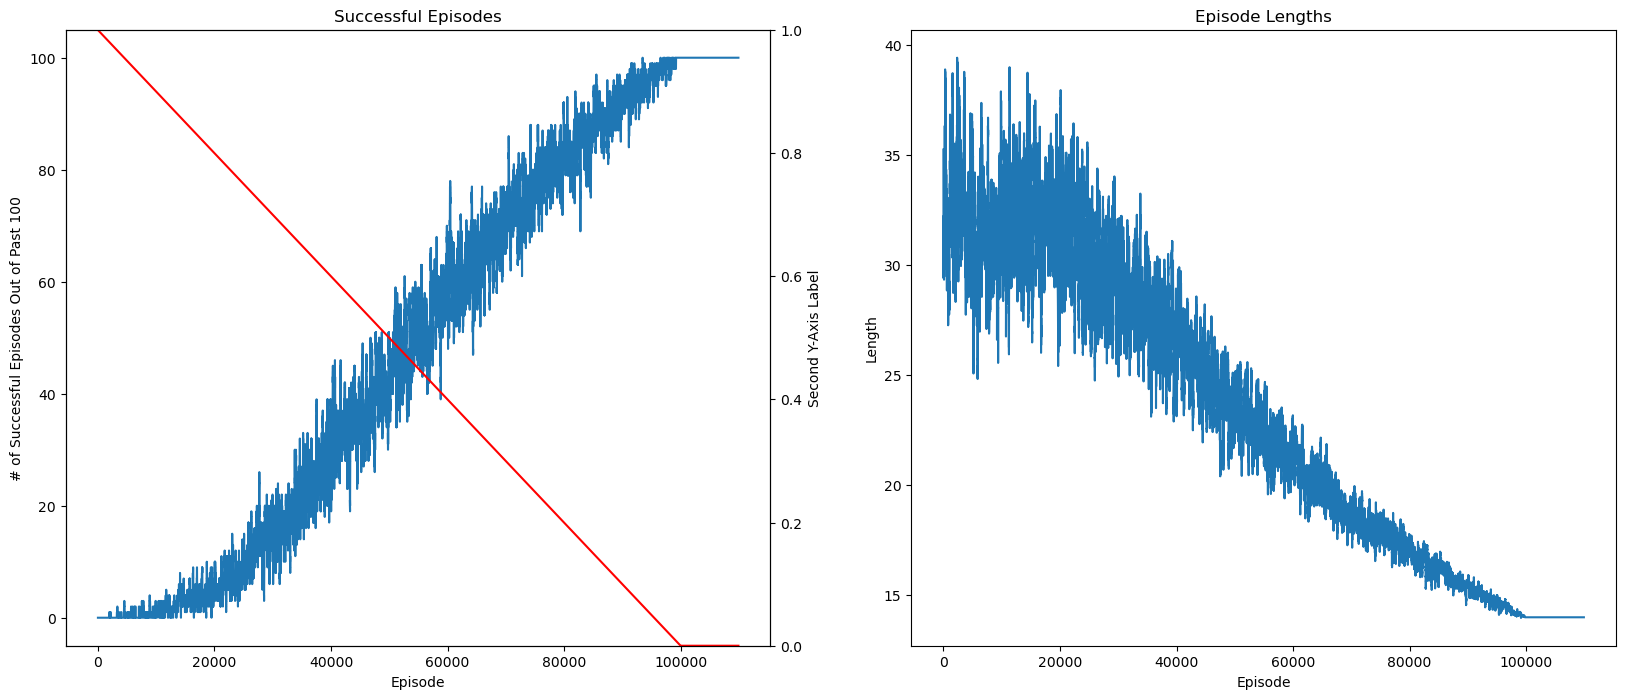

In [43]:
# render="Human" to visualize
# Slippery = False
run_episodes(110000, epsilon_change=0.00001, slippery=False, learning_rate=0.001)

Ran using the following settings:
Episodes: 20000
Learning Rate: 0.001
Discount Factor: 0.95
Initial Epsilon: 1
Epsilon Decay (per episode): 5.5e-05
Slippery: False

Ep 1999  , Epsi: 0.89  | Comp: 1  | Success Rate: 0.1 %
Ep 3999  , Epsi: 0.78  | Comp: 1  | Success Rate: 0.0 %
Ep 5999  , Epsi: 0.67  | Comp: 1  | Success Rate: 0.0 %
Ep 7999  , Epsi: 0.56  | Comp: 1  | Success Rate: 0.0 %
Ep 9999  , Epsi: 0.45  | Comp: 1  | Success Rate: 0.0 %
Ep 11999  , Epsi: 0.34  | Comp: 1  | Success Rate: 0.0 %
Ep 13999  , Epsi: 0.23  | Comp: 1  | Success Rate: 0.0 %
Ep 15999  , Epsi: 0.12  | Comp: 1  | Success Rate: 0.0 %
Ep 17999  , Epsi: 0.01  | Comp: 1  | Success Rate: 0.0 %
Ep 19999  , Epsi: 0  | Comp: 1  | Success Rate: 0.0 %

Simple Breakdown:
Episodes: 20000
Successful Episodes: 1
Failed Episodes: 19999
Success Rate: 0.005 %
Success Episode Array: [0. 0. 0. ... 0. 0. 0.]

Q-Values:
[[0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0

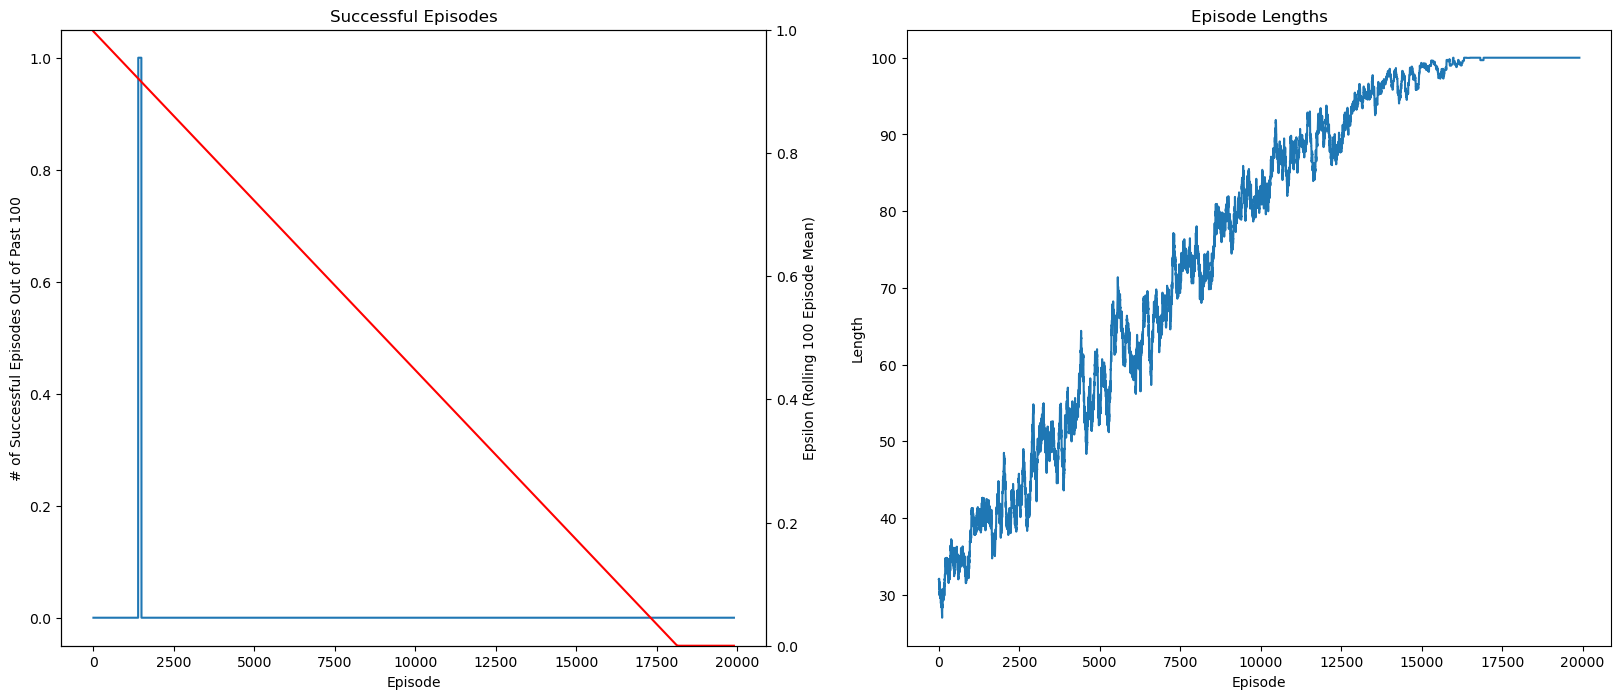

In [10]:
# Slippery = False
# Lower Episode Count
run_episodes(20000, epsilon_change=0.000055, slippery=False, learning_rate=0.001)

Ran using the following settings:
Episodes: 3500000
Learning Rate: 0.005
Discount Factor: 0.95
Initial Epsilon: 1
Epsilon Decay (per episode): 3e-07
Slippery: True

Episode 349999  , Epsilon: 0.895  | Completions so Far: 905  | Success Rate so Far: 0.3 %
Episode 699999  , Epsilon: 0.79  | Completions so Far: 2890  | Success Rate so Far: 0.4 %
Episode 1049999  , Epsilon: 0.685  | Completions so Far: 6950  | Success Rate so Far: 0.7000000000000001 %
Episode 1399999  , Epsilon: 0.58  | Completions so Far: 15033  | Success Rate so Far: 1.0999999999999999 %
Episode 1749999  , Epsilon: 0.475  | Completions so Far: 29767  | Success Rate so Far: 1.7000000000000002 %
Episode 2099999  , Epsilon: 0.37  | Completions so Far: 56174  | Success Rate so Far: 2.7 %
Episode 2449999  , Epsilon: 0.265  | Completions so Far: 102298  | Success Rate so Far: 4.2 %
Episode 2799999  , Epsilon: 0.16  | Completions so Far: 179878  | Success Rate so Far: 6.4 %
Episode 3149999  , Epsilon: 0.055  | Completions so Fa

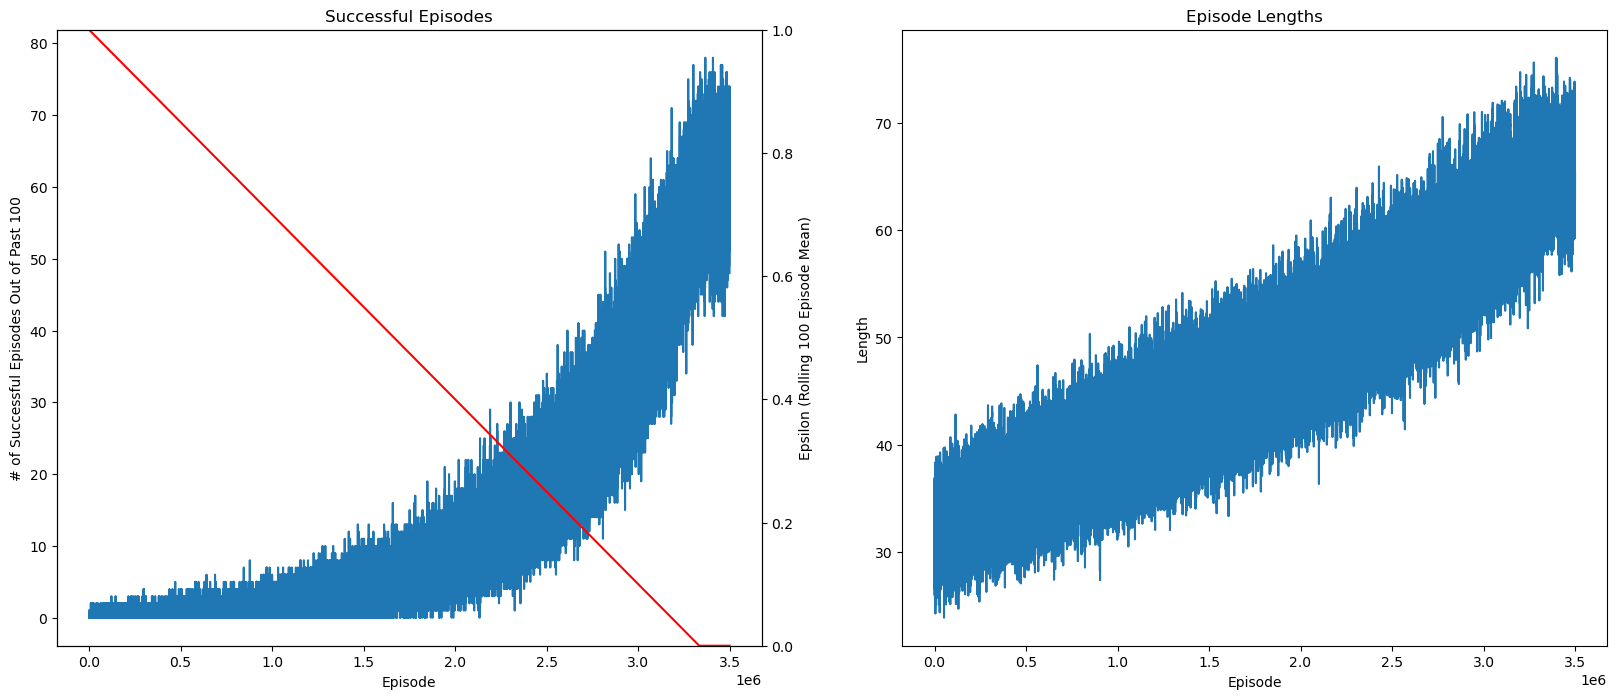

In [3]:
# Slippery = True
run_episodes(3500000, epsilon_change=0.0000003, slippery=True, learning_rate=0.005)

Ran using the following settings:
Episodes: 450000
Learning Rate: 0.005
Discount Factor: 0.95
Initial Epsilon: 1
Epsilon Decay (per episode): 3e-06
Slippery: True

Episode 44999  , Epsilon: 0.865  | Completions so Far: 146  | Success Rate so Far: 0.3 %
Episode 89999  , Epsilon: 0.73  | Completions so Far: 476  | Success Rate so Far: 0.5 %
Episode 134999  , Epsilon: 0.595  | Completions so Far: 1338  | Success Rate so Far: 1.0 %
Episode 179999  , Epsilon: 0.46  | Completions so Far: 3307  | Success Rate so Far: 1.7999999999999998 %
Episode 224999  , Epsilon: 0.325  | Completions so Far: 7387  | Success Rate so Far: 3.3000000000000003 %
Episode 269999  , Epsilon: 0.19  | Completions so Far: 15503  | Success Rate so Far: 5.7 %
Episode 314999  , Epsilon: 0.055  | Completions so Far: 30716  | Success Rate so Far: 9.8 %
Episode 359999  , Epsilon: 0  | Completions so Far: 55995  | Success Rate so Far: 15.6 %
Episode 404999  , Epsilon: 0  | Completions so Far: 82137  | Success Rate so Far: 20.

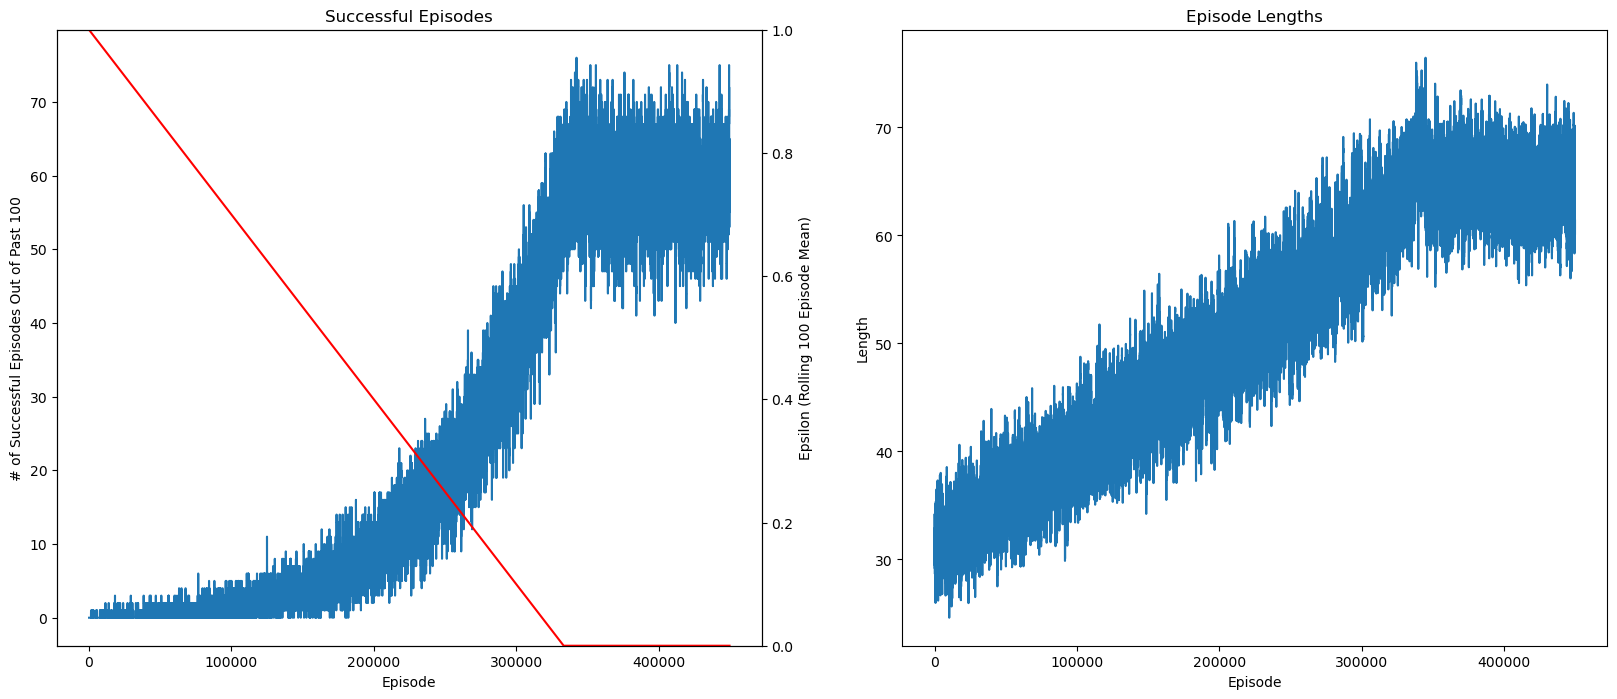

In [10]:
# Slippery = True
run_episodes(450000, epsilon_change=0.000003, slippery=True, learning_rate=0.005)

Ran using the following settings:
Episodes: 85000
Learning Rate: 0.005
Discount Factor: 0.95
Initial Epsilon: 1
Epsilon Decay (per episode): 1.3e-05
Slippery: True

Episode 8499  , Epsilon: 0.89  | Completions so Far: 24  | Success Rate so Far: 0.3 %
Episode 16999  , Epsilon: 0.779  | Completions so Far: 60  | Success Rate so Far: 0.4 %
Episode 25499  , Epsilon: 0.669  | Completions so Far: 118  | Success Rate so Far: 0.5 %
Episode 33999  , Epsilon: 0.558  | Completions so Far: 234  | Success Rate so Far: 0.7000000000000001 %
Episode 42499  , Epsilon: 0.448  | Completions so Far: 416  | Success Rate so Far: 1.0 %
Episode 50999  , Epsilon: 0.337  | Completions so Far: 1038  | Success Rate so Far: 2.0 %
Episode 59499  , Epsilon: 0.227  | Completions so Far: 2264  | Success Rate so Far: 3.8 %
Episode 67999  , Epsilon: 0.116  | Completions so Far: 4398  | Success Rate so Far: 6.5 %
Episode 76499  , Epsilon: 0.006  | Completions so Far: 8102  | Success Rate so Far: 10.6 %
Episode 84999  , E

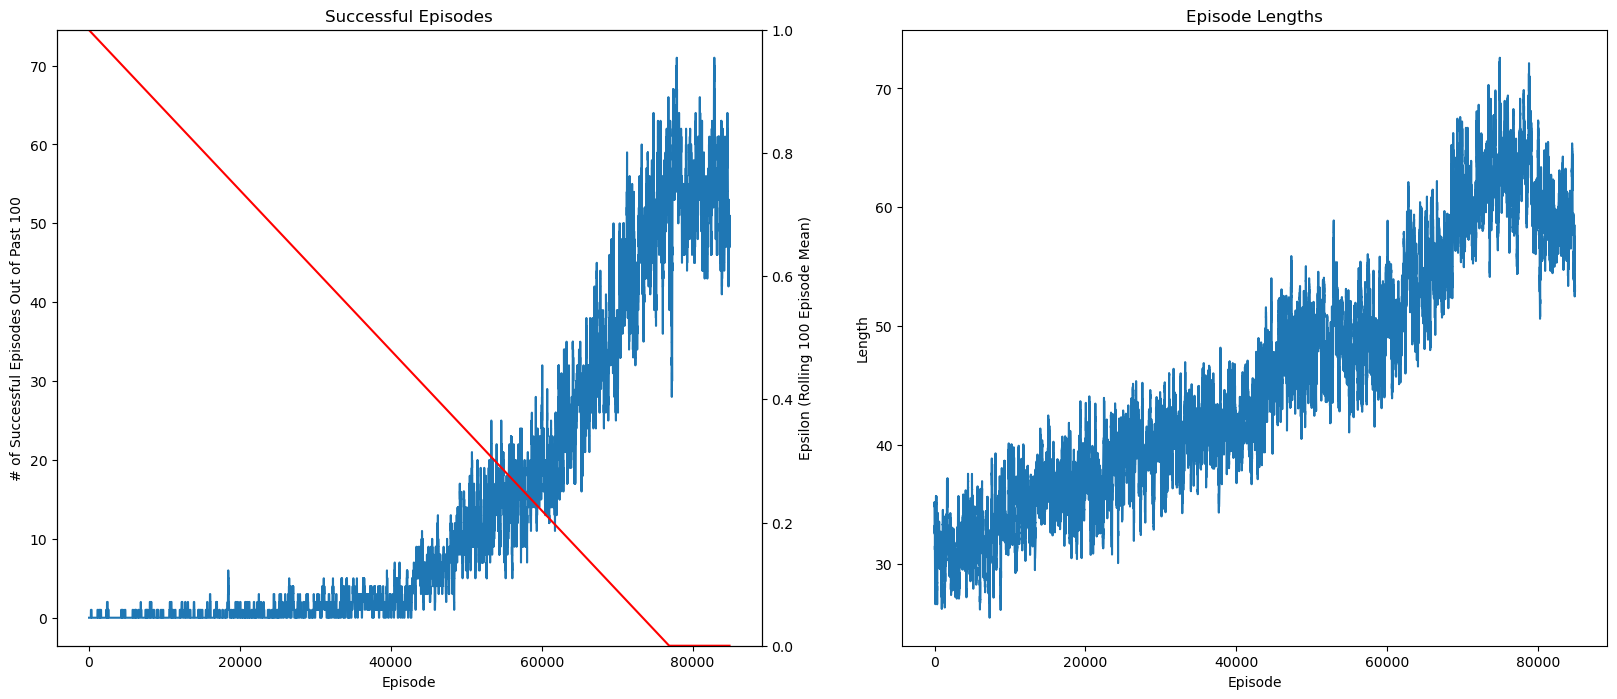

In [14]:
# Slippery = True
run_episodes(85000, epsilon_change=0.000013, slippery=True, learning_rate=0.005)

### At around ~80,000 episodes (with the slip mechanic on), the success and episode length no longer improves. The success rate converges at around 75%, with the spide length converging around 65. Using a lower episode count by any significant amount (like 40,000 as seen below) causes a much worse result (under 10% success rate). 

Ran using the following settings:
Episodes: 40000
Learning Rate: 0.005
Discount Factor: 0.95
Initial Epsilon: 1
Epsilon Decay (per episode): 2.6e-05
Slippery: True

Episode 3999  , Epsilon: 0.896  | Completions so Far: 7  | Success Rate so Far: 0.2 %
Episode 7999  , Epsilon: 0.792  | Completions so Far: 17  | Success Rate so Far: 0.2 %
Episode 11999  , Epsilon: 0.688  | Completions so Far: 33  | Success Rate so Far: 0.3 %
Episode 15999  , Epsilon: 0.584  | Completions so Far: 72  | Success Rate so Far: 0.5 %
Episode 19999  , Epsilon: 0.48  | Completions so Far: 119  | Success Rate so Far: 0.6 %
Episode 23999  , Epsilon: 0.376  | Completions so Far: 183  | Success Rate so Far: 0.8 %
Episode 27999  , Epsilon: 0.272  | Completions so Far: 248  | Success Rate so Far: 0.8999999999999999 %
Episode 31999  , Epsilon: 0.168  | Completions so Far: 371  | Success Rate so Far: 1.2 %
Episode 35999  , Epsilon: 0.064  | Completions so Far: 494  | Success Rate so Far: 1.4000000000000001 %
Episode 3999

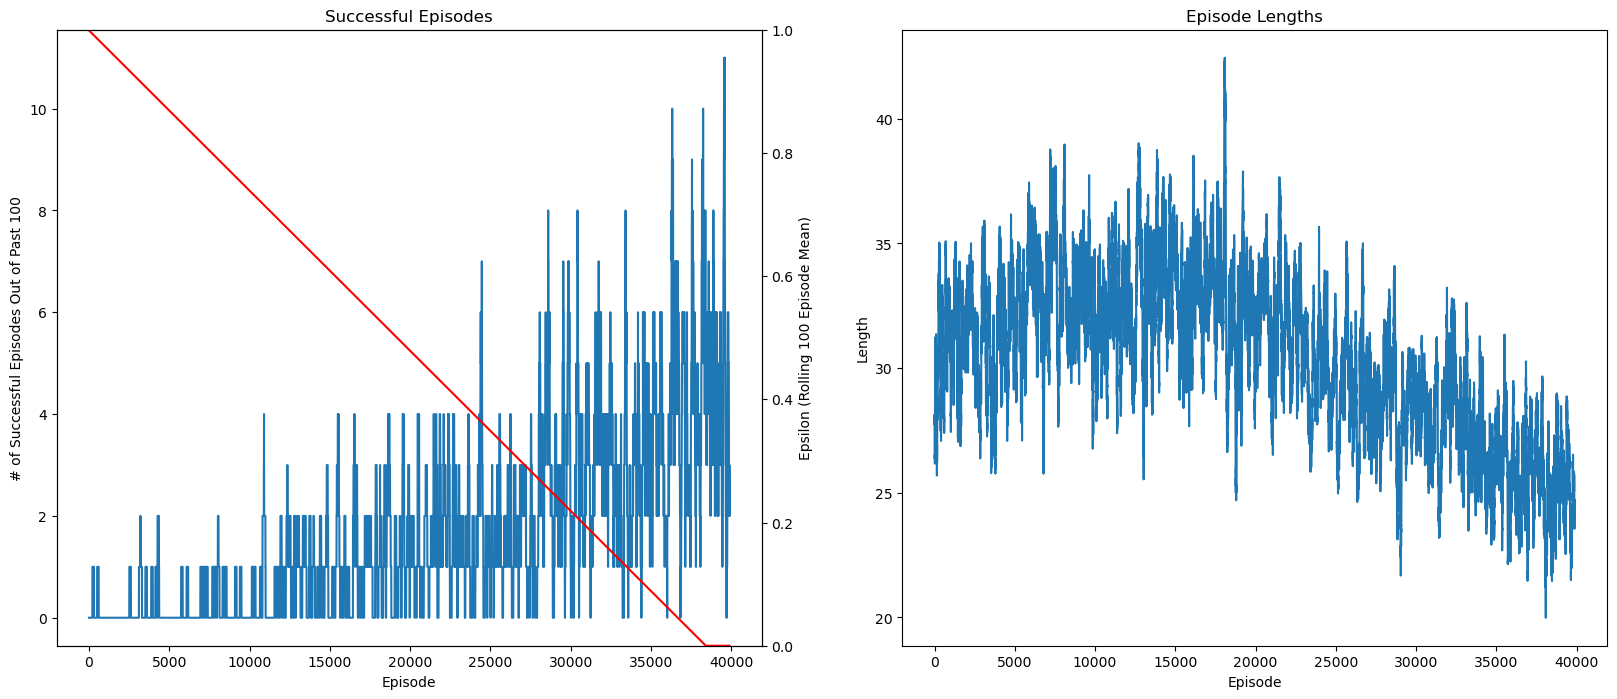

In [18]:
# Slippery = True
run_episodes(40000, epsilon_change=0.000026, slippery=True, learning_rate=0.005)

# Variables

## Episodes (with slip mode set to False)

Ran using the following settings:
Episodes: 50000
Learning Rate: 0.001
Discount Factor: 0.95
Initial Epsilon: 1
Epsilon Decay (per episode): 2.2e-05
Slippery: False

Ep 4999  , Epsi: 0.89  | Comp: 35  | Success Rate: 0.7000000000000001 %
Ep 9999  , Epsi: 0.78  | Comp: 191  | Success Rate: 1.9 %
Ep 14999  , Epsi: 0.67  | Comp: 806  | Success Rate: 5.4 %
Ep 19999  , Epsi: 0.56  | Comp: 2061  | Success Rate: 10.299999999999999 %
Ep 24999  , Epsi: 0.45  | Comp: 4119  | Success Rate: 16.5 %
Ep 29999  , Epsi: 0.34  | Comp: 6965  | Success Rate: 23.200000000000003 %
Ep 34999  , Epsi: 0.23  | Comp: 10579  | Success Rate: 30.2 %
Ep 39999  , Epsi: 0.12  | Comp: 14756  | Success Rate: 36.9 %
Ep 44999  , Epsi: 0.01  | Comp: 19511  | Success Rate: 43.4 %
Ep 49999  , Epsi: 0  | Comp: 24510  | Success Rate: 49.0 %

Simple Breakdown:
Episodes: 50000
Successful Episodes: 24511
Failed Episodes: 25489
Success Rate: 49.022 %
Success Episode Array: [  0.   0.   0. ... 100. 100. 100.]


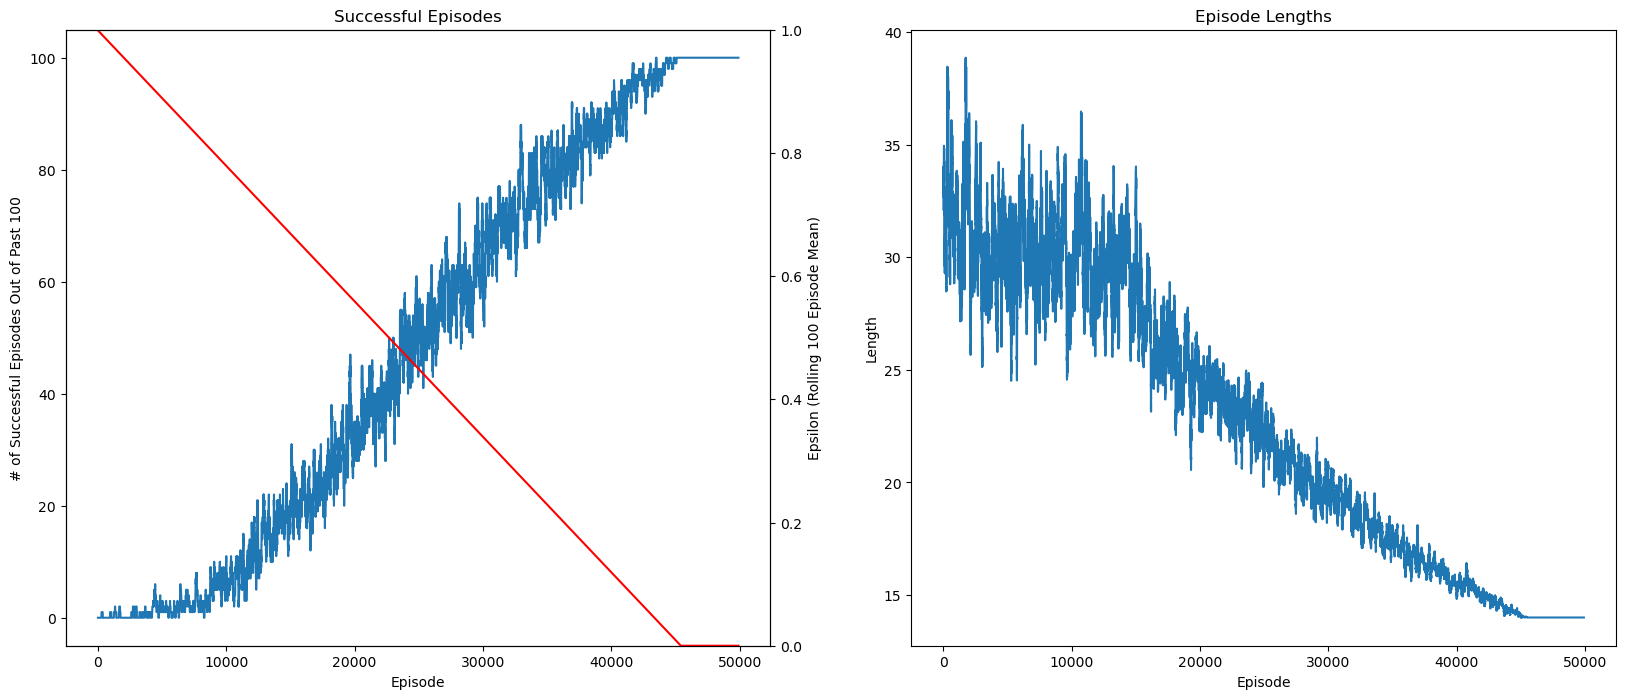

In [24]:
# render="Human" to visualize
# Slippery = False
run_episodes(50000, epsilon_change=0.000022, slippery=False, learning_rate=0.001)

Ran using the following settings:
Episodes: 20000
Learning Rate: 0.001
Discount Factor: 0.95
Initial Epsilon: 1
Epsilon Decay (per episode): 5.3e-05
Slippery: False

Ep 1999  , Epsi: 0.894  | Comp: 16  | Success Rate: 0.8 %
Ep 3999  , Epsi: 0.788  | Comp: 104  | Success Rate: 2.6 %
Ep 5999  , Epsi: 0.682  | Comp: 354  | Success Rate: 5.8999999999999995 %
Ep 7999  , Epsi: 0.576  | Comp: 843  | Success Rate: 10.5 %
Ep 9999  , Epsi: 0.47  | Comp: 1652  | Success Rate: 16.5 %
Ep 11999  , Epsi: 0.364  | Comp: 2784  | Success Rate: 23.200000000000003 %
Ep 13999  , Epsi: 0.258  | Comp: 4137  | Success Rate: 29.599999999999998 %
Ep 15999  , Epsi: 0.152  | Comp: 5740  | Success Rate: 35.9 %
Ep 17999  , Epsi: 0.046  | Comp: 7569  | Success Rate: 42.1 %
Ep 19999  , Epsi: 0  | Comp: 9556  | Success Rate: 47.8 %

Simple Breakdown:
Episodes: 20000
Successful Episodes: 9557
Failed Episodes: 10443
Success Rate: 47.785 %
Success Episode Array: [  1.   1.   1. ... 100. 100. 100.]

Q-Values:
[[2.81814580

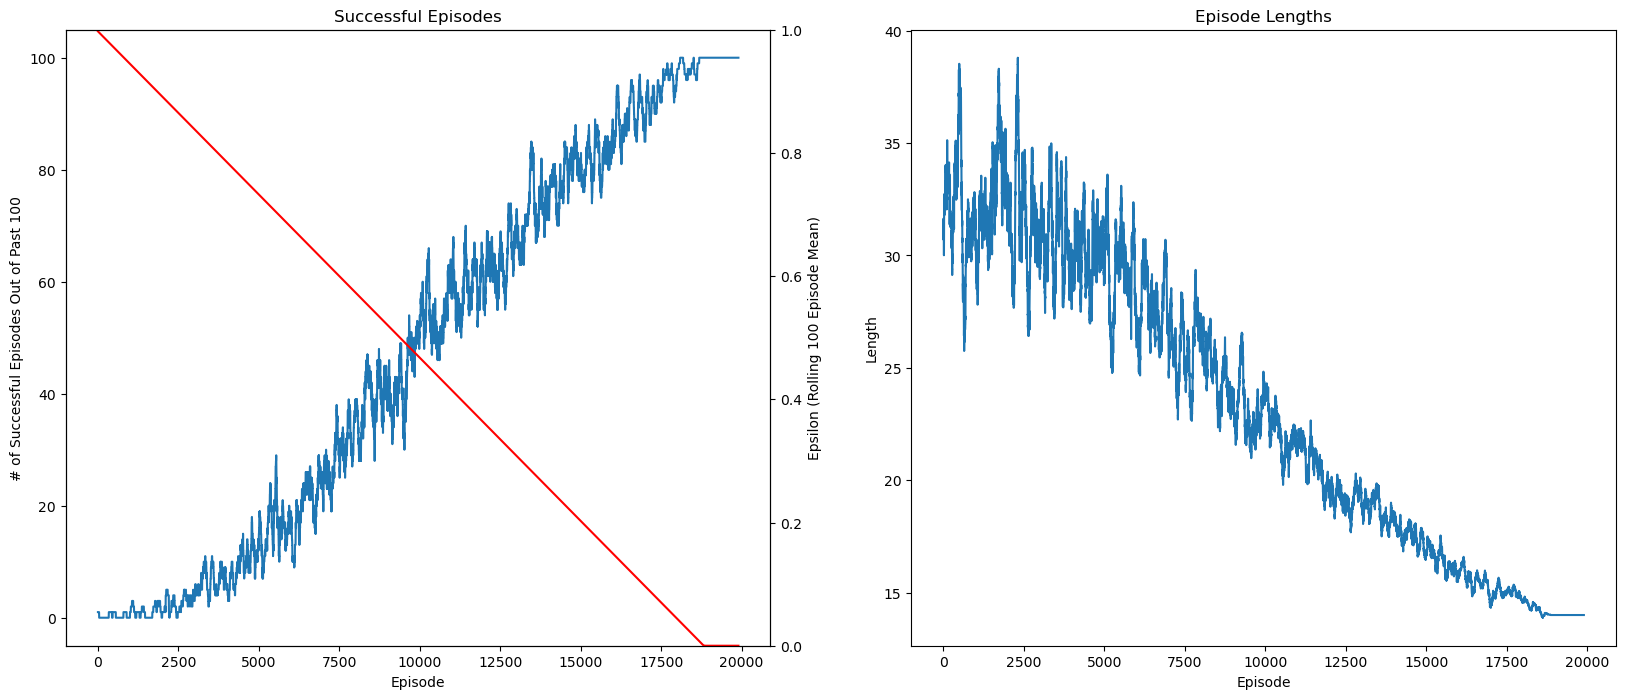

In [10]:
# render="Human" to visualize
# Slippery = False
run_episodes(20000, epsilon_change=0.000053, slippery=False, learning_rate=0.001)

Ran using the following settings:
Episodes: 10000
Learning Rate: 0.001
Discount Factor: 0.95
Initial Epsilon: 1
Epsilon Decay (per episode): 0.00011
Slippery: False

Episode 999  , Epsilon: 0.89  | Completions so Far: 0  | Success Rate so Far: 0.0 %
Episode 1999  , Epsilon: 0.78  | Completions so Far: 0  | Success Rate so Far: 0.0 %
Episode 2999  , Epsilon: 0.67  | Completions so Far: 0  | Success Rate so Far: 0.0 %
Episode 3999  , Epsilon: 0.56  | Completions so Far: 0  | Success Rate so Far: 0.0 %
Episode 4999  , Epsilon: 0.45  | Completions so Far: 0  | Success Rate so Far: 0.0 %
Episode 5999  , Epsilon: 0.34  | Completions so Far: 0  | Success Rate so Far: 0.0 %
Episode 6999  , Epsilon: 0.23  | Completions so Far: 0  | Success Rate so Far: 0.0 %
Episode 7999  , Epsilon: 0.12  | Completions so Far: 0  | Success Rate so Far: 0.0 %
Episode 8999  , Epsilon: 0.01  | Completions so Far: 0  | Success Rate so Far: 0.0 %
Episode 9999  , Epsilon: 0  | Completions so Far: 0  | Success Rate so

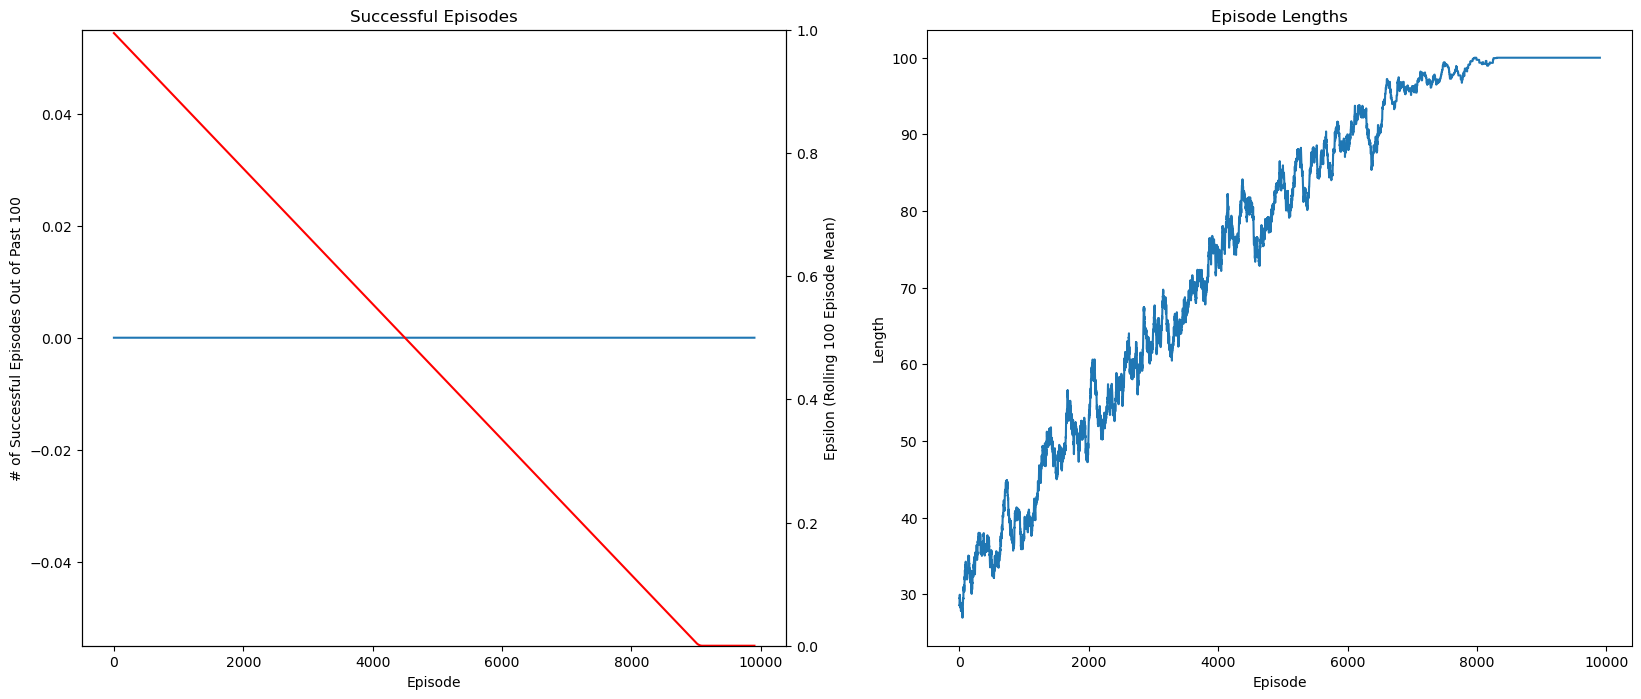

In [29]:
# render="Human" to visualize
# Slippery = False
run_episodes(10000, epsilon_change=0.00011, slippery=False, learning_rate=0.001)

Ran using the following settings:
Episodes: 10000
Learning Rate: 0.001
Discount Factor: 0.95
Initial Epsilon: 1
Epsilon Decay (per episode): 0.00011
Slippery: False

Episode 999  , Epsilon: 0.89  | Completions so Far: 7  | Success Rate so Far: 0.7000000000000001 %
Episode 1999  , Epsilon: 0.78  | Completions so Far: 40  | Success Rate so Far: 2.0 %
Episode 2999  , Epsilon: 0.67  | Completions so Far: 153  | Success Rate so Far: 5.1 %
Episode 3999  , Epsilon: 0.56  | Completions so Far: 415  | Success Rate so Far: 10.4 %
Episode 4999  , Epsilon: 0.45  | Completions so Far: 827  | Success Rate so Far: 16.5 %
Episode 5999  , Epsilon: 0.34  | Completions so Far: 1423  | Success Rate so Far: 23.7 %
Episode 6999  , Epsilon: 0.23  | Completions so Far: 2132  | Success Rate so Far: 30.5 %
Episode 7999  , Epsilon: 0.12  | Completions so Far: 2979  | Success Rate so Far: 37.2 %
Episode 8999  , Epsilon: 0.01  | Completions so Far: 3924  | Success Rate so Far: 43.6 %
Episode 9999  , Epsilon: 0  | 

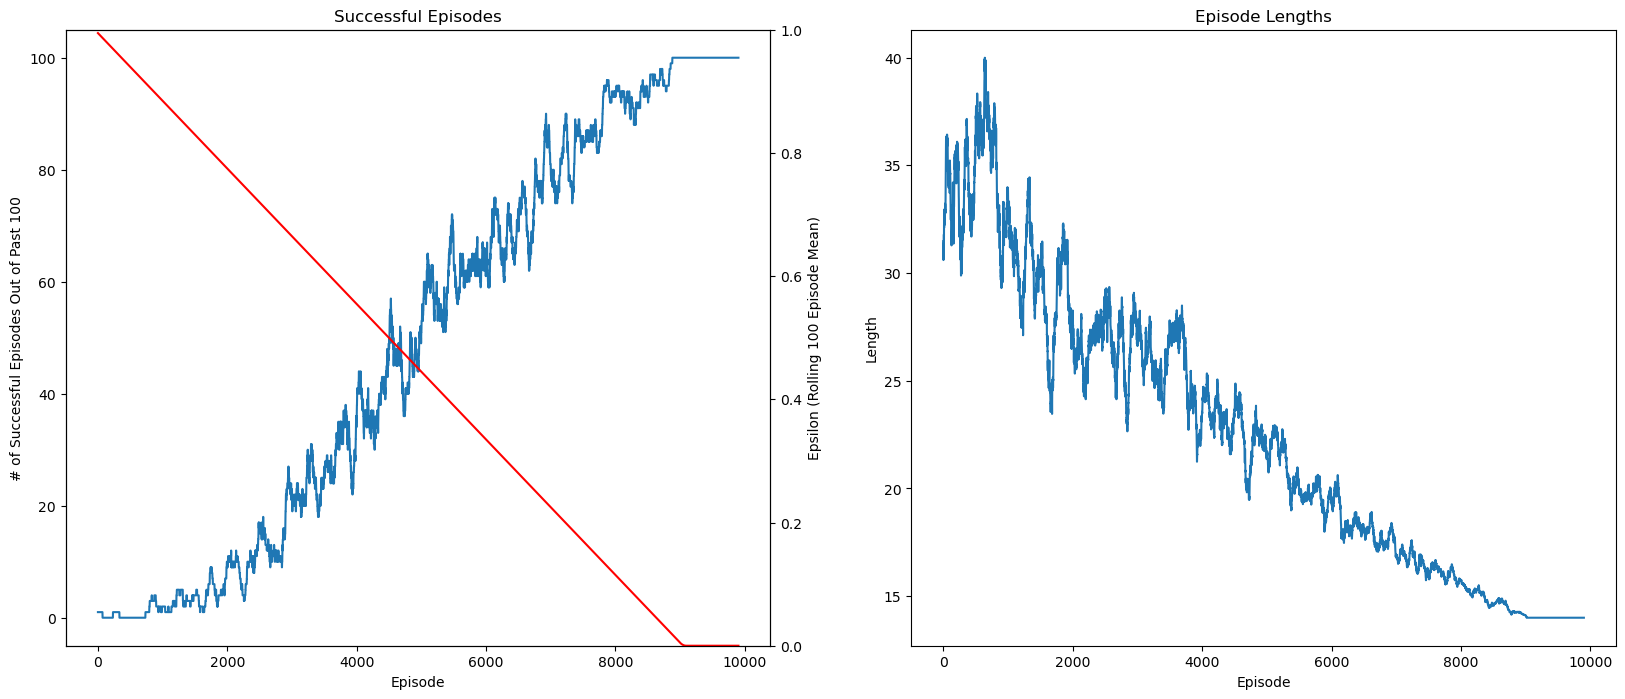

In [30]:
# render="Human" to visualize
# Slippery = False
run_episodes(10000, epsilon_change=0.00011, slippery=False, learning_rate=0.001)

While the successful episode rate does converge at 100% when we always take the action we want to take (slip mode off), the episode count needed can vary. If a low episode count like 10,000 is used, it is sometimes possible for the Q-Learning algorithm to never find a correct path on time while the epsilon is still high.

## Learning Rate

Ran using the following settings:
Episodes: 50000
Learning Rate: 0.95
Discount Factor: 0.95
Initial Epsilon: 1
Epsilon Decay (per episode): 2.3e-05
Slippery: False

Episode 4999  , Epsilon: 0.885  | Completions so Far: 24  | Success Rate so Far: 0.5 %
Episode 9999  , Epsilon: 0.77  | Completions so Far: 61  | Success Rate so Far: 0.6 %
Episode 14999  , Epsilon: 0.655  | Completions so Far: 179  | Success Rate so Far: 1.2 %
Episode 19999  , Epsilon: 0.54  | Completions so Far: 464  | Success Rate so Far: 2.3 %
Episode 24999  , Epsilon: 0.425  | Completions so Far: 1125  | Success Rate so Far: 4.5 %
Episode 29999  , Epsilon: 0.31  | Completions so Far: 2539  | Success Rate so Far: 8.5 %
Episode 34999  , Epsilon: 0.195  | Completions so Far: 4860  | Success Rate so Far: 13.900000000000002 %
Episode 39999  , Epsilon: 0.08  | Completions so Far: 8331  | Success Rate so Far: 20.8 %
Episode 44999  , Epsilon: 0  | Completions so Far: 13020  | Success Rate so Far: 28.9 %
Episode 49999  , Epsilo

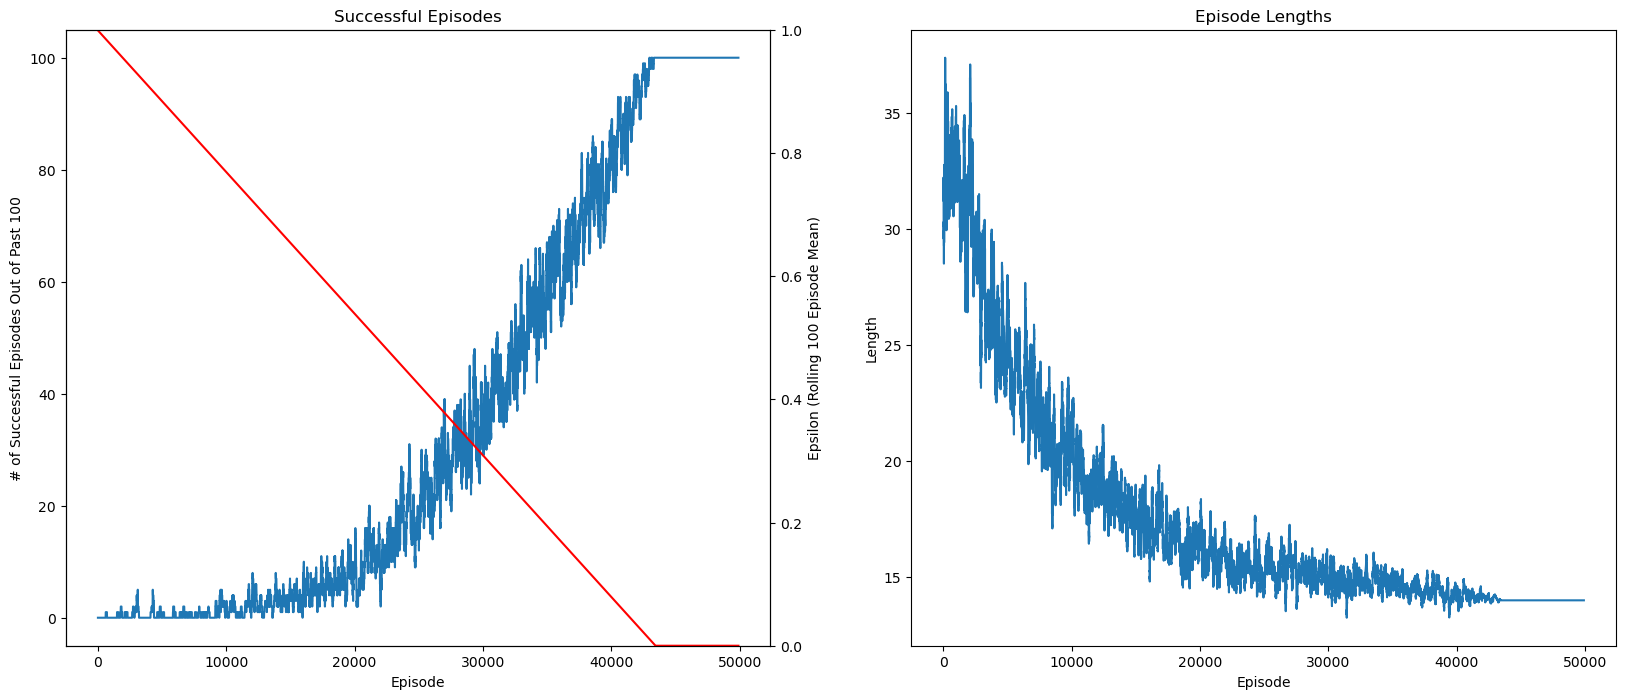

In [45]:
# render="Human" to visualize
# Slippery = False
run_episodes(50000, epsilon_change=0.000023, slippery=False, learning_rate=0.95)

Ran using the following settings:
Episodes: 50000
Learning Rate: 0.8
Discount Factor: 0.95
Initial Epsilon: 1
Epsilon Decay (per episode): 2.3e-05
Slippery: False

Episode 4999  , Epsilon: 0.885  | Completions so Far: 28  | Success Rate so Far: 0.6 %
Episode 9999  , Epsilon: 0.77  | Completions so Far: 64  | Success Rate so Far: 0.6 %
Episode 14999  , Epsilon: 0.655  | Completions so Far: 188  | Success Rate so Far: 1.3 %
Episode 19999  , Epsilon: 0.54  | Completions so Far: 509  | Success Rate so Far: 2.5 %
Episode 24999  , Epsilon: 0.425  | Completions so Far: 1162  | Success Rate so Far: 4.6 %
Episode 29999  , Epsilon: 0.31  | Completions so Far: 2477  | Success Rate so Far: 8.3 %
Episode 34999  , Epsilon: 0.195  | Completions so Far: 4709  | Success Rate so Far: 13.5 %
Episode 39999  , Epsilon: 0.08  | Completions so Far: 8141  | Success Rate so Far: 20.4 %
Episode 44999  , Epsilon: 0  | Completions so Far: 12856  | Success Rate so Far: 28.599999999999998 %
Episode 49999  , Epsilon

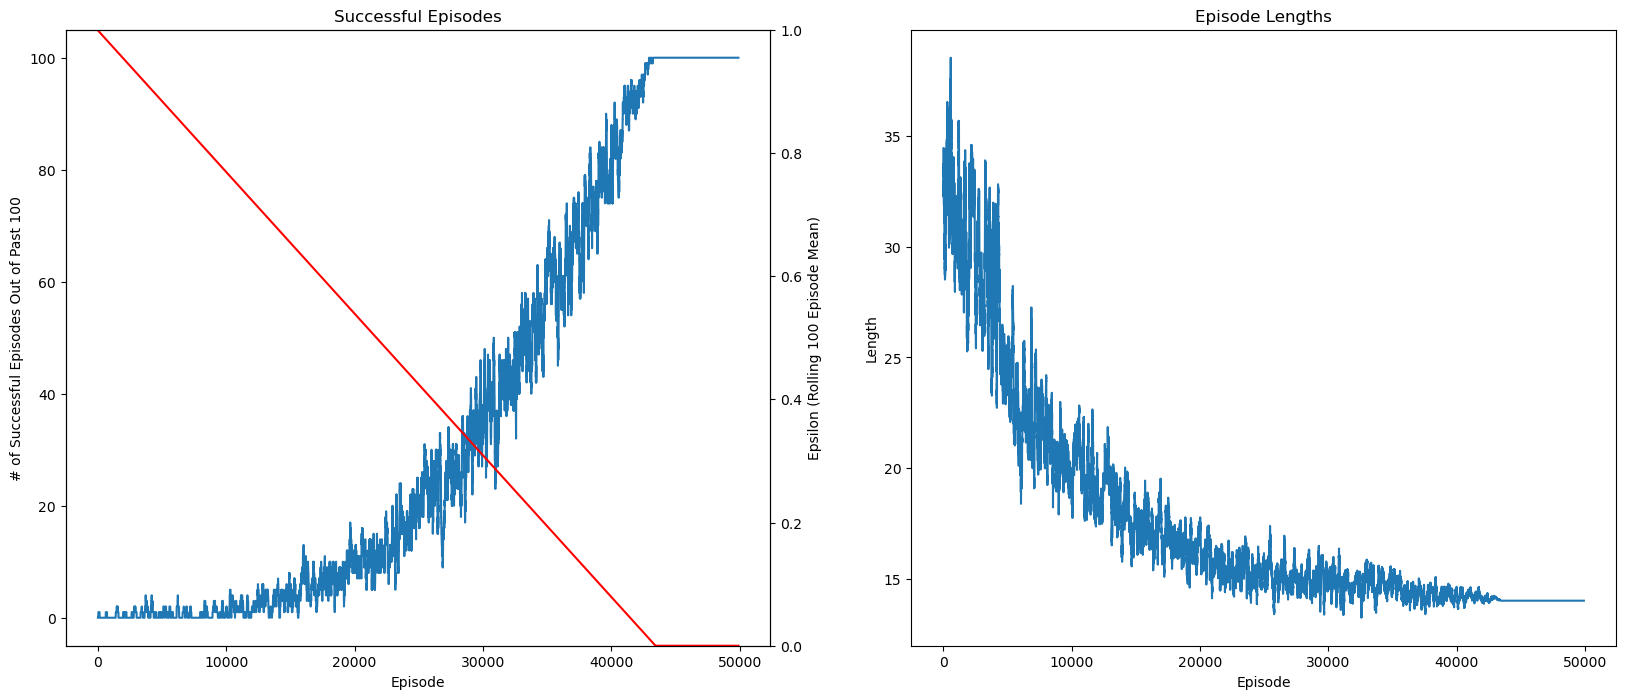

In [46]:
# render="Human" to visualize
# Slippery = False
run_episodes(50000, epsilon_change=0.000023, slippery=False, learning_rate=0.8)

Ran using the following settings:
Episodes: 50000
Learning Rate: 0.5
Discount Factor: 0.95
Initial Epsilon: 1
Epsilon Decay (per episode): 2.3e-05
Slippery: False

Episode 4999  , Epsilon: 0.885  | Completions so Far: 37  | Success Rate so Far: 0.7000000000000001 %
Episode 9999  , Epsilon: 0.77  | Completions so Far: 90  | Success Rate so Far: 0.8999999999999999 %
Episode 14999  , Epsilon: 0.655  | Completions so Far: 218  | Success Rate so Far: 1.5 %
Episode 19999  , Epsilon: 0.54  | Completions so Far: 523  | Success Rate so Far: 2.6 %
Episode 24999  , Epsilon: 0.425  | Completions so Far: 1200  | Success Rate so Far: 4.8 %
Episode 29999  , Epsilon: 0.31  | Completions so Far: 2575  | Success Rate so Far: 8.6 %
Episode 34999  , Epsilon: 0.195  | Completions so Far: 4804  | Success Rate so Far: 13.700000000000001 %
Episode 39999  , Epsilon: 0.08  | Completions so Far: 8249  | Success Rate so Far: 20.599999999999998 %
Episode 44999  , Epsilon: 0  | Completions so Far: 12920  | Success 

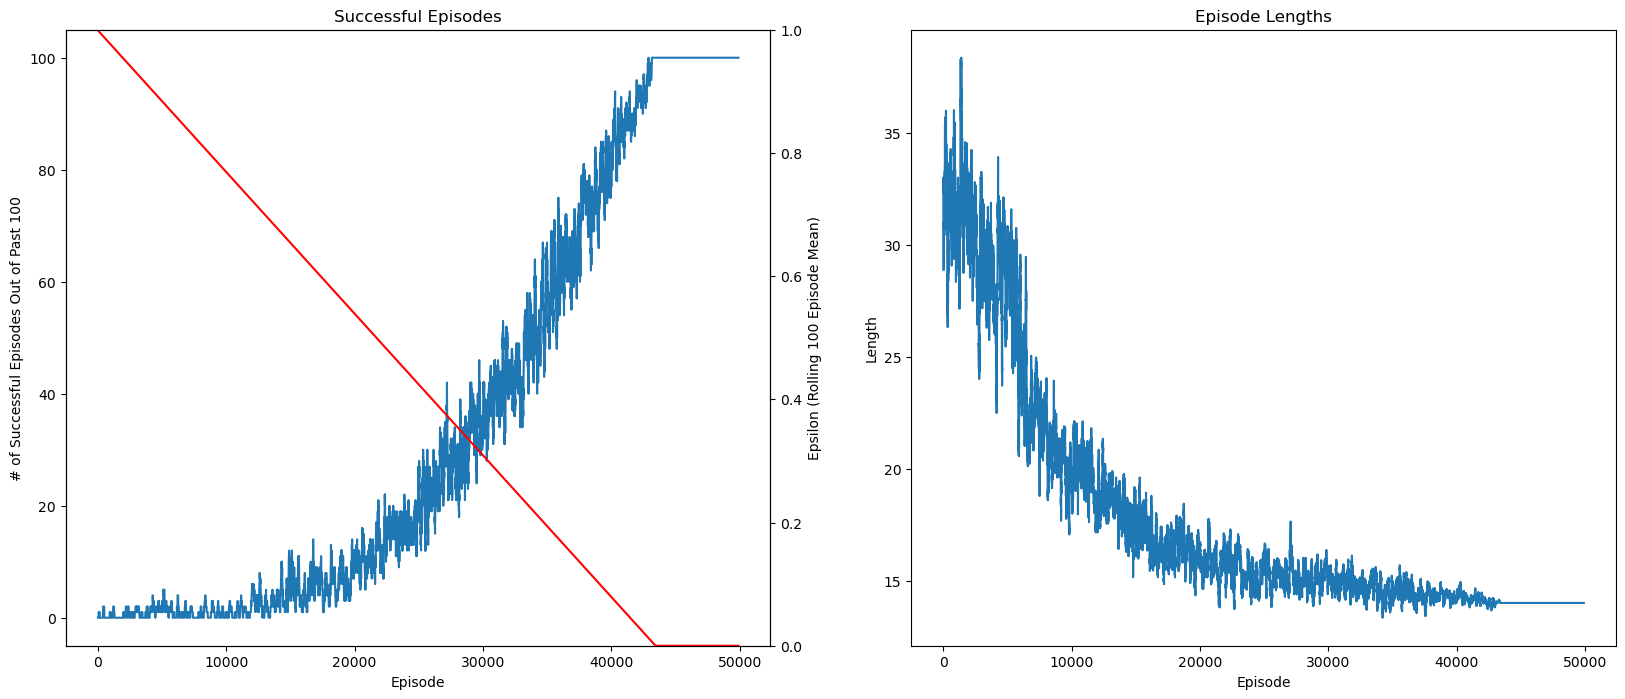

In [47]:
# render="Human" to visualize
# Slippery = False
run_episodes(50000, epsilon_change=0.000023, slippery=False, learning_rate=0.5)

Ran using the following settings:
Episodes: 50000
Learning Rate: 0.2
Discount Factor: 0.95
Initial Epsilon: 1
Epsilon Decay (per episode): 2.3e-05
Slippery: False

Episode 4999  , Epsilon: 0.885  | Completions so Far: 31  | Success Rate so Far: 0.6 %
Episode 9999  , Epsilon: 0.77  | Completions so Far: 190  | Success Rate so Far: 1.9 %
Episode 14999  , Epsilon: 0.655  | Completions so Far: 322  | Success Rate so Far: 2.1 %
Episode 19999  , Epsilon: 0.54  | Completions so Far: 647  | Success Rate so Far: 3.2 %
Episode 24999  , Epsilon: 0.425  | Completions so Far: 1409  | Success Rate so Far: 5.6000000000000005 %
Episode 29999  , Epsilon: 0.31  | Completions so Far: 2945  | Success Rate so Far: 9.8 %
Episode 34999  , Epsilon: 0.195  | Completions so Far: 5366  | Success Rate so Far: 15.299999999999999 %
Episode 39999  , Epsilon: 0.08  | Completions so Far: 8967  | Success Rate so Far: 22.400000000000002 %
Episode 44999  , Epsilon: 0  | Completions so Far: 13678  | Success Rate so Far: 3

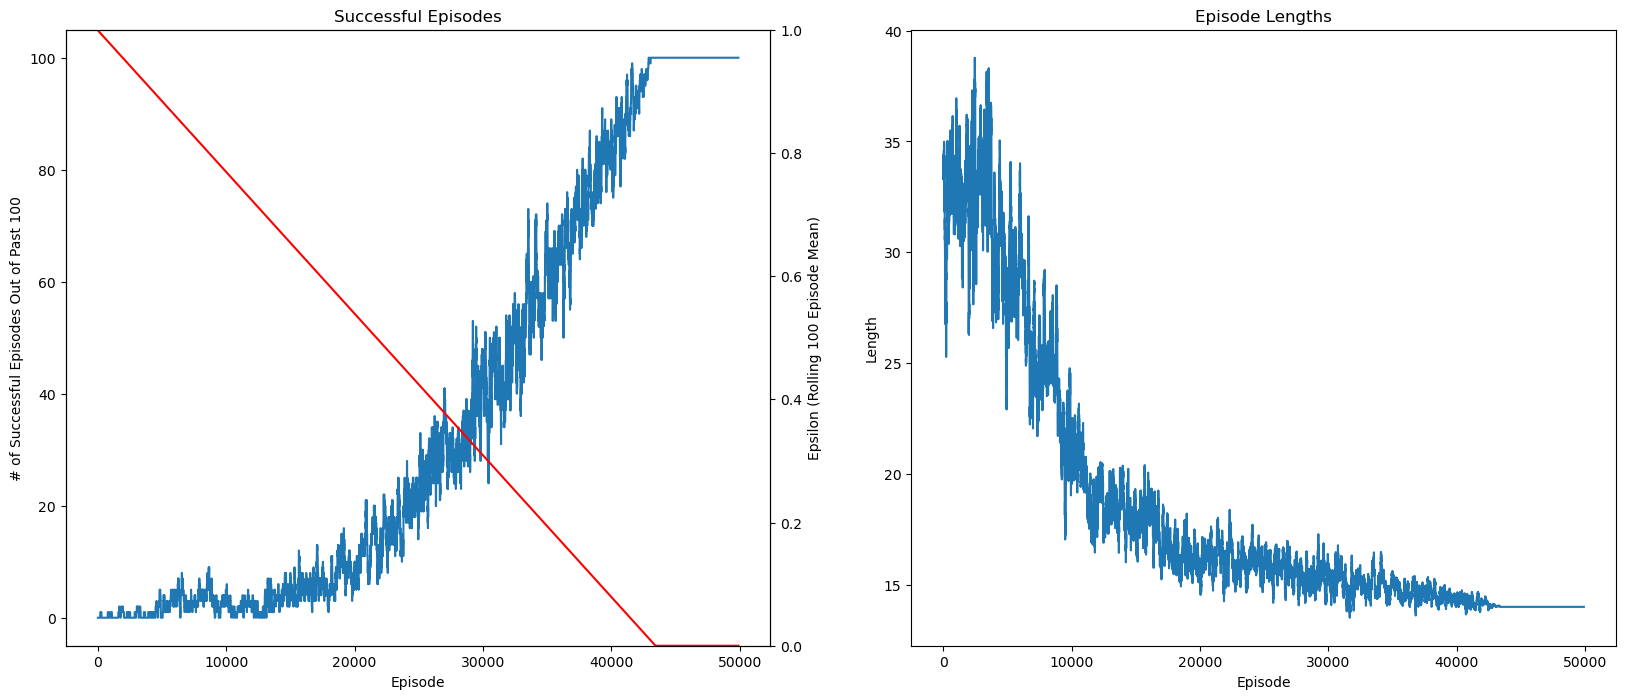

In [48]:
# render="Human" to visualize
# Slippery = False
run_episodes(50000, epsilon_change=0.000023, slippery=False, learning_rate=0.2)

Ran using the following settings:
Episodes: 50000
Learning Rate: 0.05
Discount Factor: 0.95
Initial Epsilon: 1
Epsilon Decay (per episode): 2.3e-05
Slippery: False

Episode 4999  , Epsilon: 0.885  | Completions so Far: 43  | Success Rate so Far: 0.8999999999999999 %
Episode 9999  , Epsilon: 0.77  | Completions so Far: 250  | Success Rate so Far: 2.5 %
Episode 14999  , Epsilon: 0.655  | Completions so Far: 822  | Success Rate so Far: 5.5 %
Episode 19999  , Epsilon: 0.54  | Completions so Far: 1516  | Success Rate so Far: 7.6 %
Episode 24999  , Epsilon: 0.425  | Completions so Far: 2392  | Success Rate so Far: 9.6 %
Episode 29999  , Epsilon: 0.31  | Completions so Far: 4052  | Success Rate so Far: 13.5 %
Episode 34999  , Epsilon: 0.195  | Completions so Far: 6532  | Success Rate so Far: 18.7 %
Episode 39999  , Epsilon: 0.08  | Completions so Far: 10172  | Success Rate so Far: 25.4 %
Episode 44999  , Epsilon: 0  | Completions so Far: 14890  | Success Rate so Far: 33.1 %
Episode 49999  , E

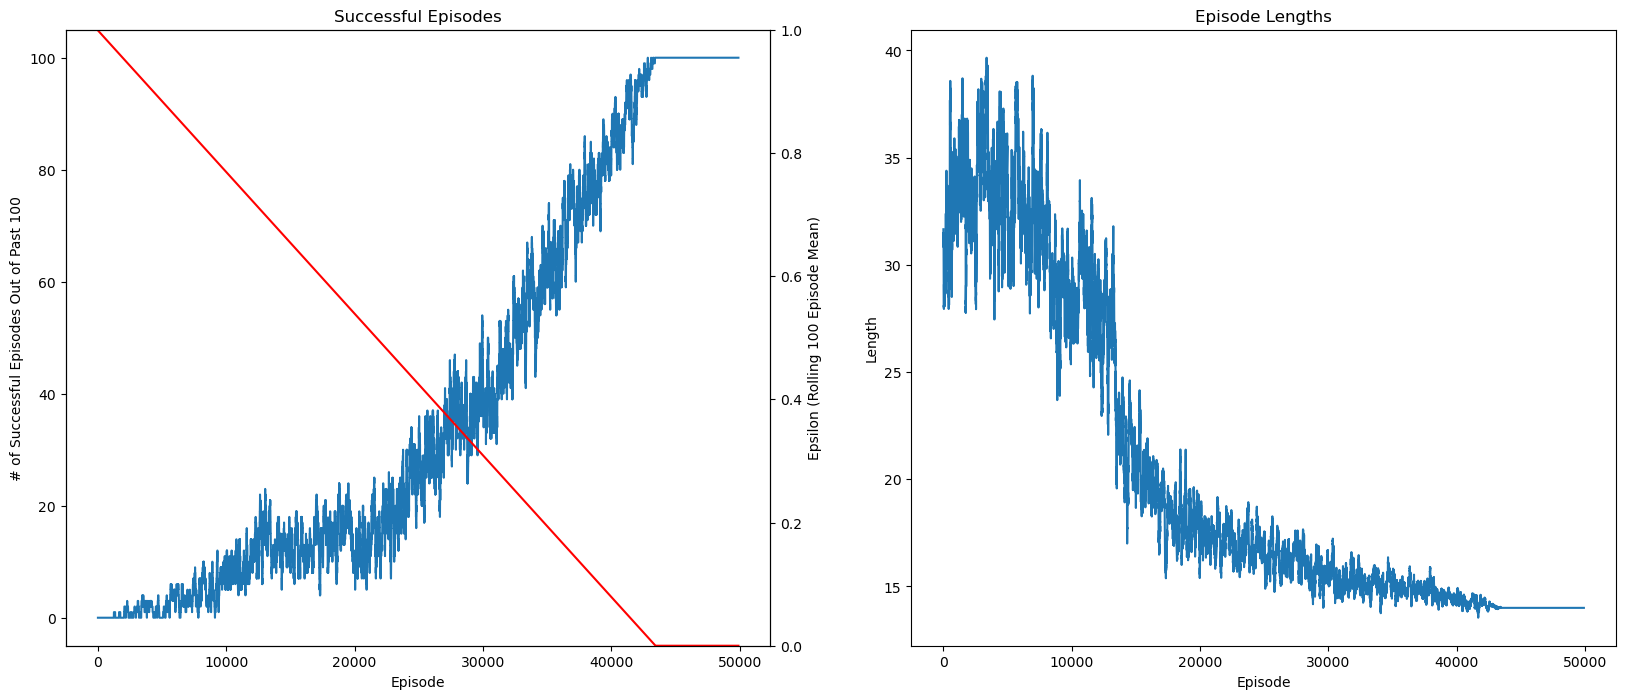

In [49]:
# render="Human" to visualize
# Slippery = False
run_episodes(50000, epsilon_change=0.000023, slippery=False, learning_rate=0.05)

Ran using the following settings:
Episodes: 50000
Learning Rate: 0.02
Discount Factor: 0.95
Initial Epsilon: 1
Epsilon Decay (per episode): 2.3e-05
Slippery: False

Episode 4999  , Epsilon: 0.885  | Completions so Far: 39  | Success Rate so Far: 0.8 %
Episode 9999  , Epsilon: 0.77  | Completions so Far: 239  | Success Rate so Far: 2.4 %
Episode 14999  , Epsilon: 0.655  | Completions so Far: 897  | Success Rate so Far: 6.0 %
Episode 19999  , Epsilon: 0.54  | Completions so Far: 2327  | Success Rate so Far: 11.600000000000001 %
Episode 24999  , Epsilon: 0.425  | Completions so Far: 4313  | Success Rate so Far: 17.299999999999997 %
Episode 29999  , Epsilon: 0.31  | Completions so Far: 6655  | Success Rate so Far: 22.2 %
Episode 34999  , Epsilon: 0.195  | Completions so Far: 9799  | Success Rate so Far: 28.000000000000004 %
Episode 39999  , Epsilon: 0.08  | Completions so Far: 13779  | Success Rate so Far: 34.4 %
Episode 44999  , Epsilon: 0  | Completions so Far: 18594  | Success Rate so F

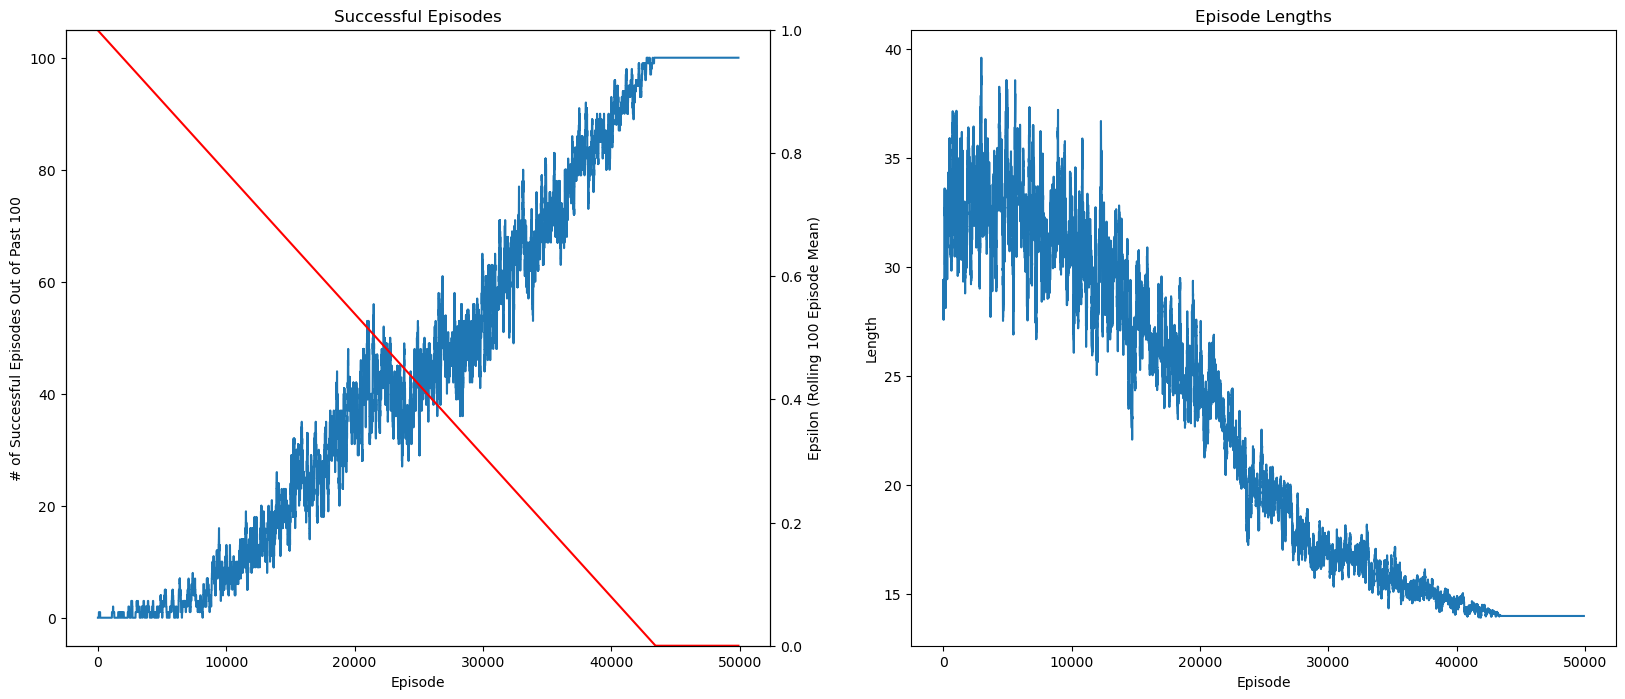

In [50]:
# render="Human" to visualize
# Slippery = False
run_episodes(50000, epsilon_change=0.000023, slippery=False, learning_rate=0.02)

Ran using the following settings:
Episodes: 50000
Learning Rate: 0.01
Discount Factor: 0.95
Initial Epsilon: 1
Epsilon Decay (per episode): 2.3e-05
Slippery: False

Episode 4999  , Epsilon: 0.885  | Completions so Far: 29  | Success Rate so Far: 0.6 %
Episode 9999  , Epsilon: 0.77  | Completions so Far: 233  | Success Rate so Far: 2.3 %
Episode 14999  , Epsilon: 0.655  | Completions so Far: 947  | Success Rate so Far: 6.3 %
Episode 19999  , Epsilon: 0.54  | Completions so Far: 2387  | Success Rate so Far: 11.899999999999999 %
Episode 24999  , Epsilon: 0.425  | Completions so Far: 4671  | Success Rate so Far: 18.7 %
Episode 29999  , Epsilon: 0.31  | Completions so Far: 7671  | Success Rate so Far: 25.6 %
Episode 34999  , Epsilon: 0.195  | Completions so Far: 11464  | Success Rate so Far: 32.800000000000004 %
Episode 39999  , Epsilon: 0.08  | Completions so Far: 15877  | Success Rate so Far: 39.7 %
Episode 44999  , Epsilon: 0  | Completions so Far: 20760  | Success Rate so Far: 46.1 %
Ep

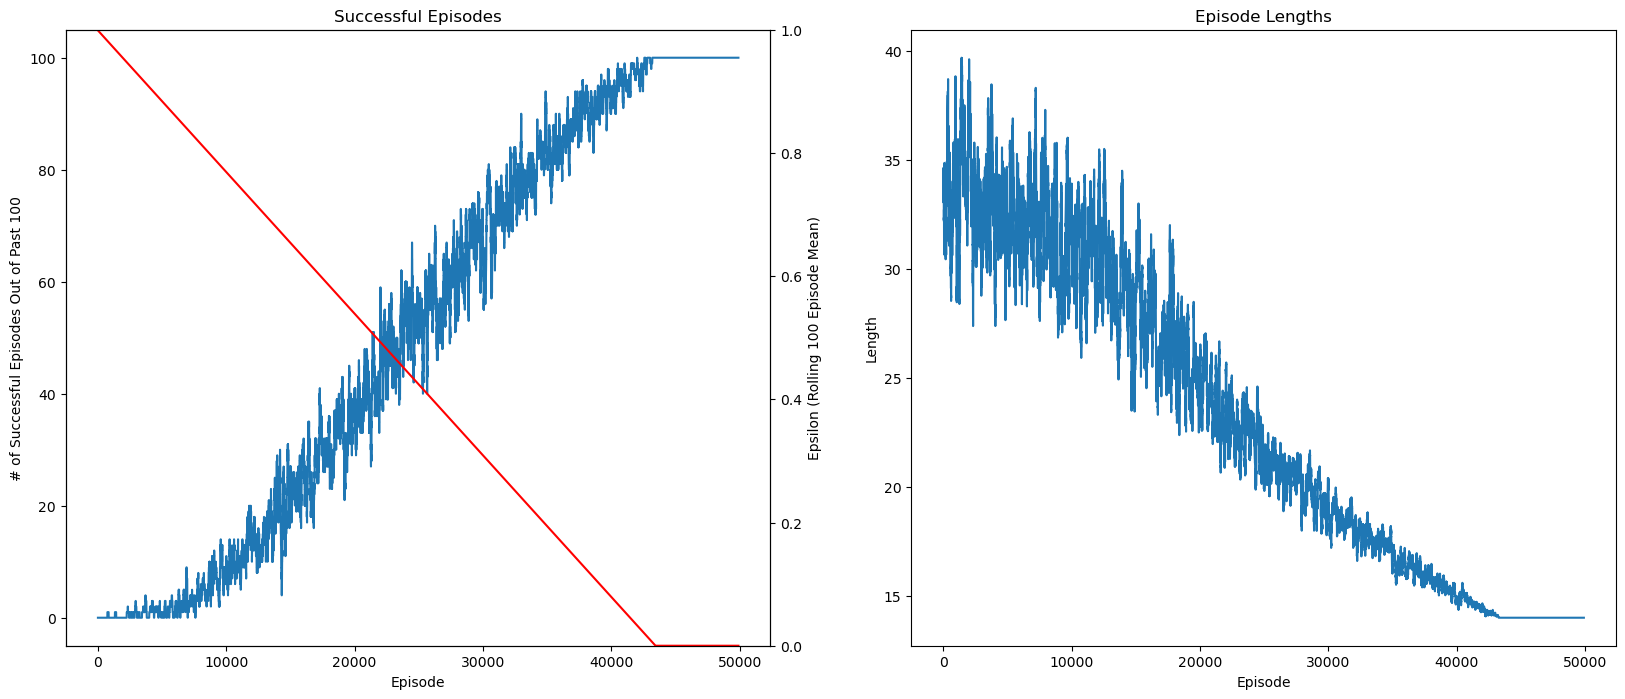

In [51]:
# render="Human" to visualize
# Slippery = False
run_episodes(50000, epsilon_change=0.000023, slippery=False, learning_rate=0.01)

Ran using the following settings:
Episodes: 50000
Learning Rate: 0.001
Discount Factor: 0.95
Initial Epsilon: 1
Epsilon Decay (per episode): 2.3e-05
Slippery: False

Episode 4999  , Epsilon: 0.885  | Completions so Far: 30  | Success Rate so Far: 0.6 %
Episode 9999  , Epsilon: 0.77  | Completions so Far: 248  | Success Rate so Far: 2.5 %
Episode 14999  , Epsilon: 0.655  | Completions so Far: 919  | Success Rate so Far: 6.1 %
Episode 19999  , Epsilon: 0.54  | Completions so Far: 2357  | Success Rate so Far: 11.799999999999999 %
Episode 24999  , Epsilon: 0.425  | Completions so Far: 4620  | Success Rate so Far: 18.5 %
Episode 29999  , Epsilon: 0.31  | Completions so Far: 7711  | Success Rate so Far: 25.7 %
Episode 34999  , Epsilon: 0.195  | Completions so Far: 11510  | Success Rate so Far: 32.9 %
Episode 39999  , Epsilon: 0.08  | Completions so Far: 15920  | Success Rate so Far: 39.800000000000004 %
Episode 44999  , Epsilon: 0  | Completions so Far: 20798  | Success Rate so Far: 46.2 %
E

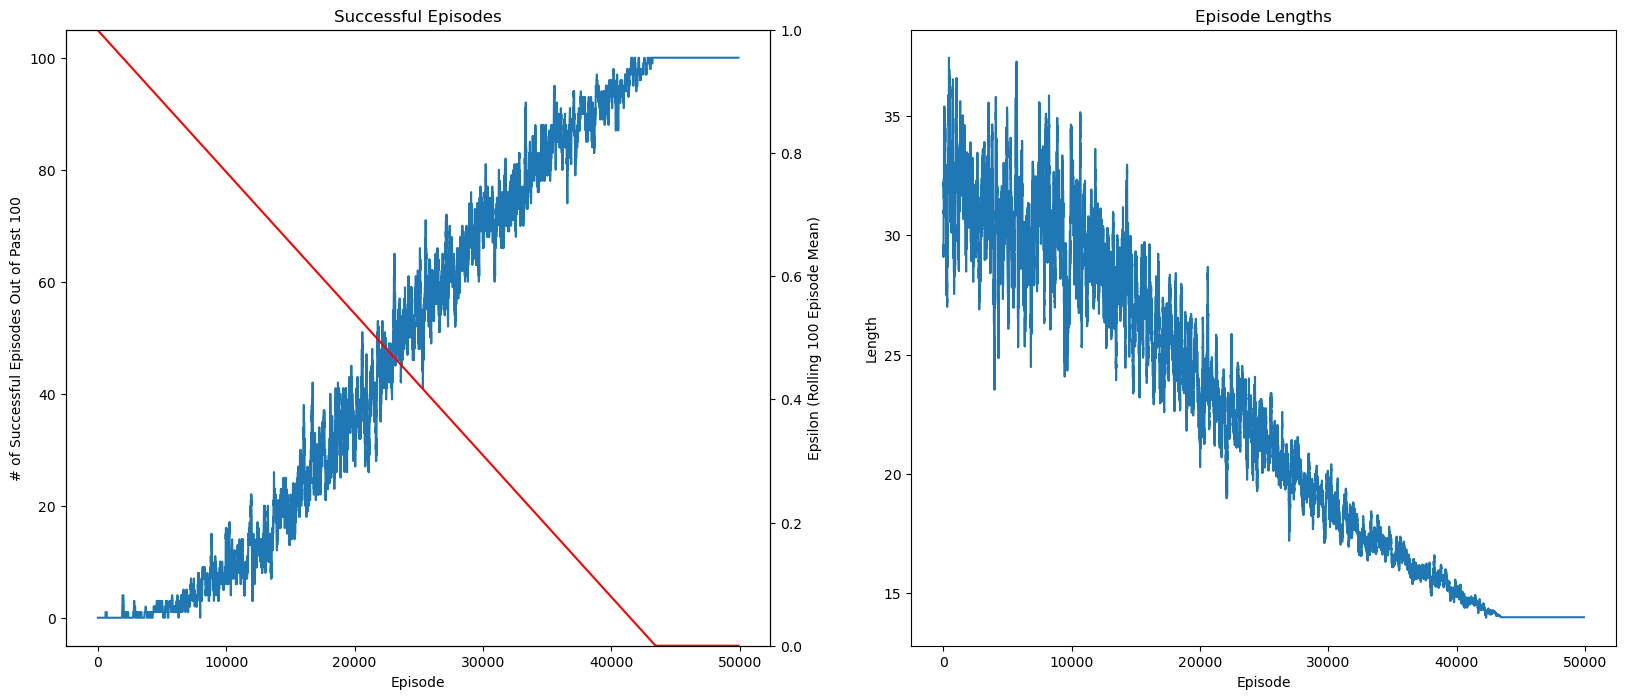

In [52]:
# render="Human" to visualize
# Slippery = False
run_episodes(50000, epsilon_change=0.000023, slippery=False, learning_rate=0.001)

Ran using the following settings:
Episodes: 50000
Learning Rate: 0.0001
Discount Factor: 0.95
Initial Epsilon: 1
Epsilon Decay (per episode): 2.3e-05
Slippery: False

Episode 4999  , Epsilon: 0.885  | Completions so Far: 31  | Success Rate so Far: 0.6 %
Episode 9999  , Epsilon: 0.77  | Completions so Far: 187  | Success Rate so Far: 1.9 %
Episode 14999  , Epsilon: 0.655  | Completions so Far: 696  | Success Rate so Far: 4.6 %
Episode 19999  , Epsilon: 0.54  | Completions so Far: 1873  | Success Rate so Far: 9.4 %
Episode 24999  , Epsilon: 0.425  | Completions so Far: 3983  | Success Rate so Far: 15.9 %
Episode 29999  , Epsilon: 0.31  | Completions so Far: 7008  | Success Rate so Far: 23.400000000000002 %
Episode 34999  , Epsilon: 0.195  | Completions so Far: 10774  | Success Rate so Far: 30.8 %
Episode 39999  , Epsilon: 0.08  | Completions so Far: 15190  | Success Rate so Far: 38.0 %
Episode 44999  , Epsilon: 0  | Completions so Far: 20082  | Success Rate so Far: 44.6 %
Episode 49999  

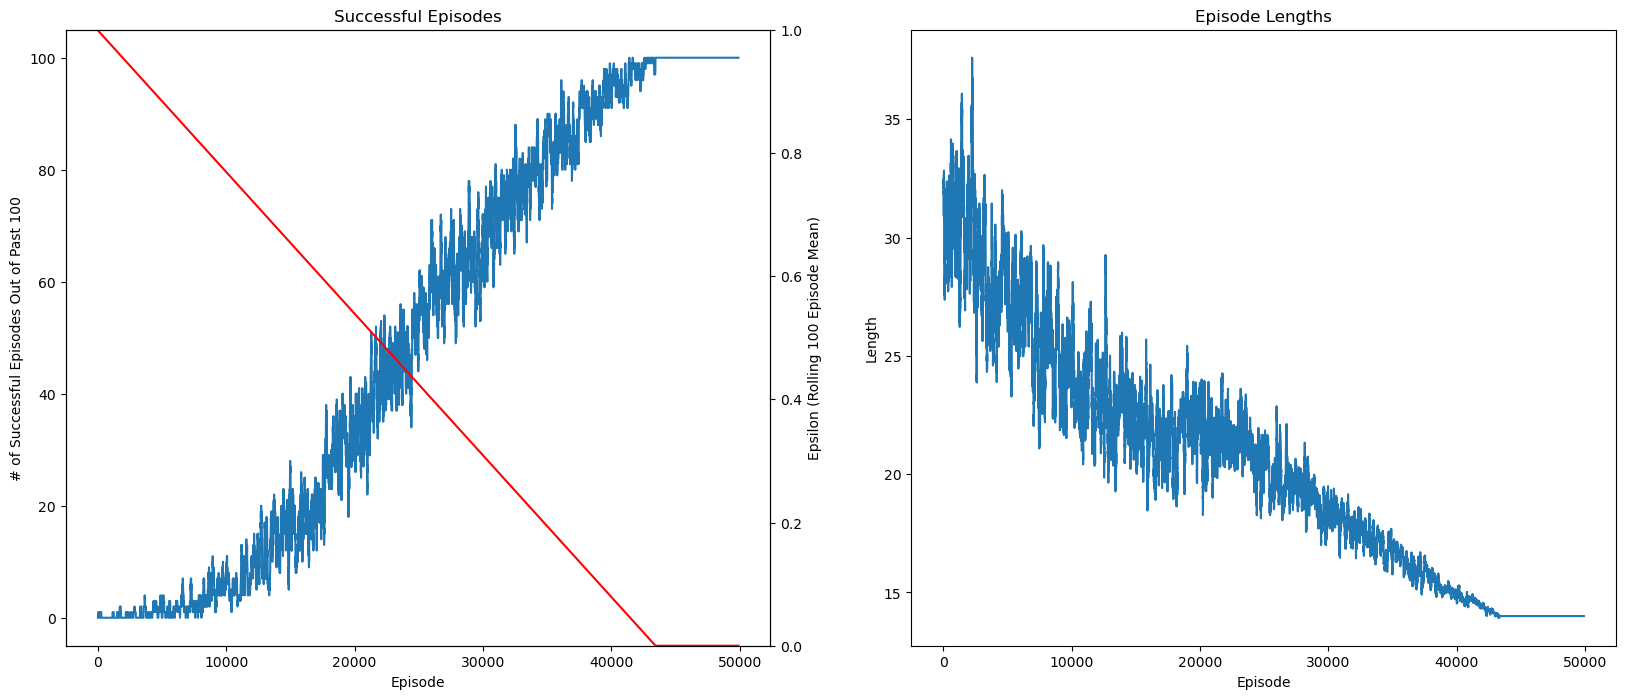

In [53]:
# render="Human" to visualize
# Slippery = False
run_episodes(50000, epsilon_change=0.000023, slippery=False, learning_rate=0.0001)

Ran using the following settings:
Episodes: 50000
Learning Rate: 1e-05
Discount Factor: 0.95
Initial Epsilon: 1
Epsilon Decay (per episode): 2.3e-05
Slippery: False

Episode 4999  , Epsilon: 0.885  | Completions so Far: 23  | Success Rate so Far: 0.5 %
Episode 9999  , Epsilon: 0.77  | Completions so Far: 192  | Success Rate so Far: 1.9 %
Episode 14999  , Epsilon: 0.655  | Completions so Far: 749  | Success Rate so Far: 5.0 %
Episode 19999  , Epsilon: 0.54  | Completions so Far: 1976  | Success Rate so Far: 9.9 %
Episode 24999  , Epsilon: 0.425  | Completions so Far: 3898  | Success Rate so Far: 15.6 %
Episode 29999  , Epsilon: 0.31  | Completions so Far: 6668  | Success Rate so Far: 22.2 %
Episode 34999  , Epsilon: 0.195  | Completions so Far: 10325  | Success Rate so Far: 29.5 %
Episode 39999  , Epsilon: 0.08  | Completions so Far: 14671  | Success Rate so Far: 36.7 %
Episode 44999  , Epsilon: 0  | Completions so Far: 19558  | Success Rate so Far: 43.5 %
Episode 49999  , Epsilon: 0  |

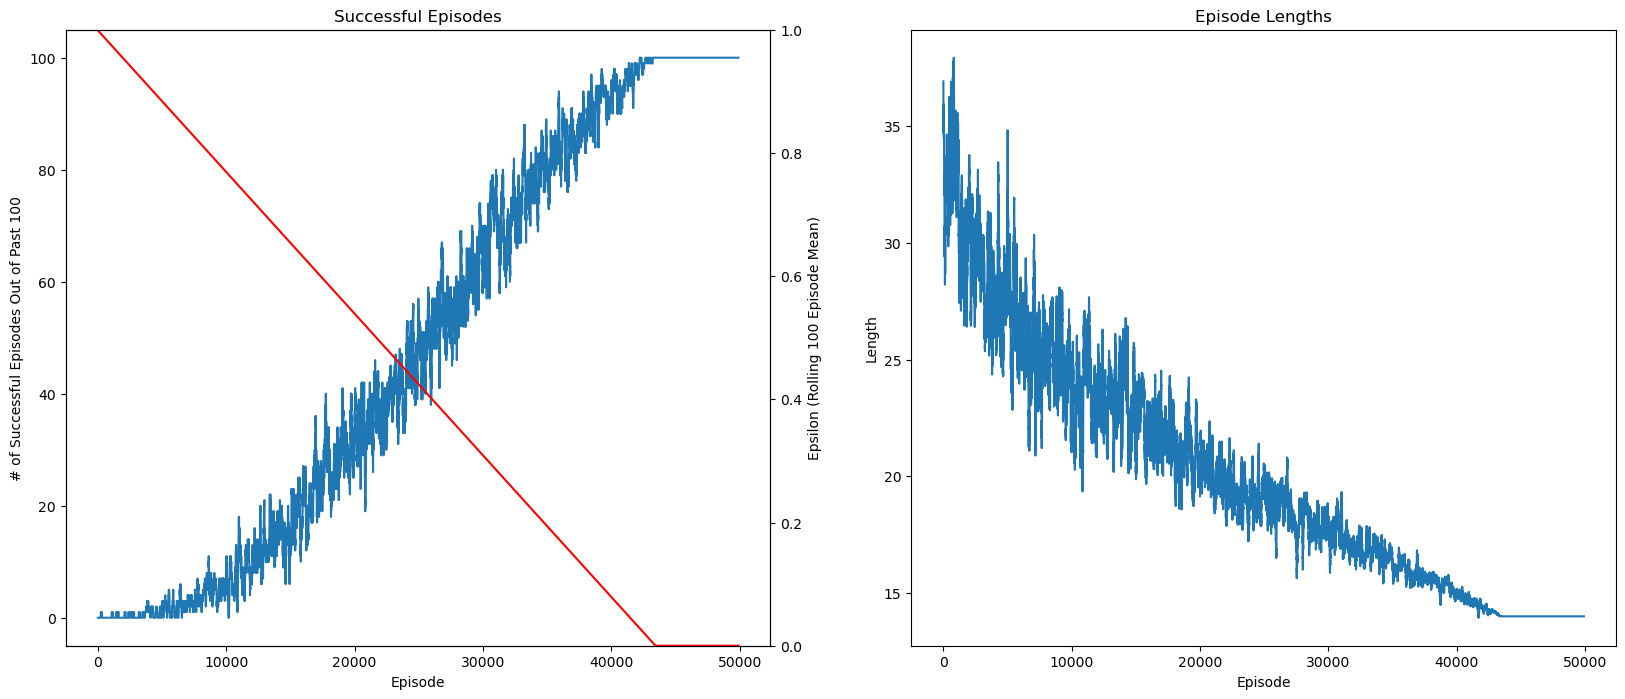

In [55]:
# render="Human" to visualize
# Slippery = False
run_episodes(50000, epsilon_change=0.000023, slippery=False, learning_rate=0.00001)

### A low learning rate (learning_rate=0.01 to learning_rate=0.001) appeared to perform best. Going any lower or higher overall negatively impacts the end results.

## Discount Factor

Ran using the following settings:
Episodes: 50000
Learning Rate: 0.05
Discount Factor: 0.2
Initial Epsilon: 1
Epsilon Decay (per episode): 2.3e-05
Slippery: False

Episode 4999  , Epsilon: 0.885  | Completions so Far: 38  | Success Rate so Far: 0.8 %
Episode 9999  , Epsilon: 0.77  | Completions so Far: 199  | Success Rate so Far: 2.0 %
Episode 14999  , Epsilon: 0.655  | Completions so Far: 705  | Success Rate so Far: 4.7 %
Episode 19999  , Epsilon: 0.54  | Completions so Far: 1417  | Success Rate so Far: 7.1 %
Episode 24999  , Epsilon: 0.425  | Completions so Far: 2366  | Success Rate so Far: 9.5 %
Episode 29999  , Epsilon: 0.31  | Completions so Far: 4065  | Success Rate so Far: 13.600000000000001 %
Episode 34999  , Epsilon: 0.195  | Completions so Far: 6691  | Success Rate so Far: 19.1 %
Episode 39999  , Epsilon: 0.08  | Completions so Far: 10374  | Success Rate so Far: 25.900000000000002 %
Episode 44999  , Epsilon: 0  | Completions so Far: 15097  | Success Rate so Far: 33.5 %
Episod

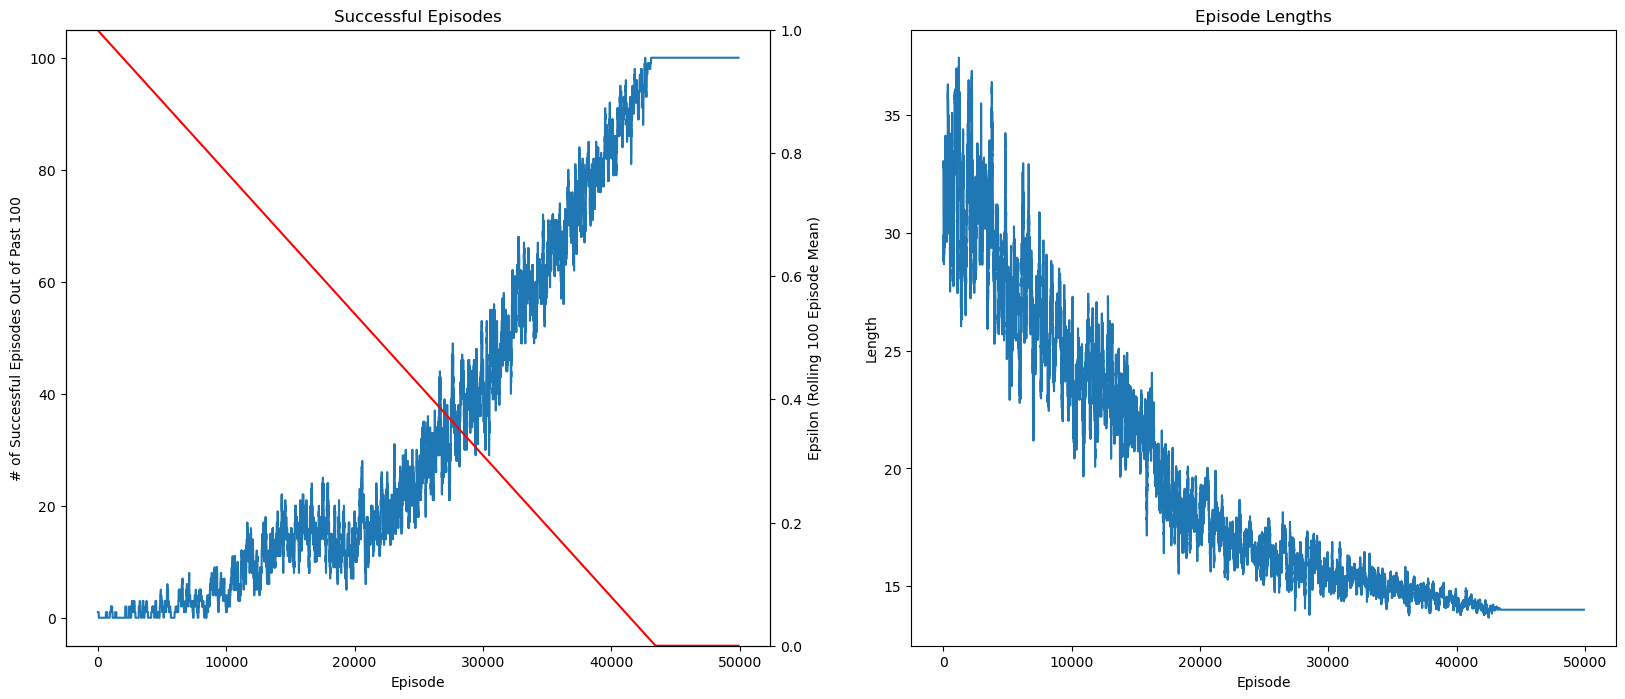

In [61]:
# render="Human" to visualize
# Slippery = False
run_episodes(50000, epsilon_change=0.000023, slippery=False, discount_factor=0.2)

Ran using the following settings:
Episodes: 50000
Learning Rate: 0.05
Discount Factor: 0.5
Initial Epsilon: 1
Epsilon Decay (per episode): 2.3e-05
Slippery: False

Episode 4999  , Epsilon: 0.885  | Completions so Far: 43  | Success Rate so Far: 0.8999999999999999 %
Episode 9999  , Epsilon: 0.77  | Completions so Far: 218  | Success Rate so Far: 2.1999999999999997 %
Episode 14999  , Epsilon: 0.655  | Completions so Far: 775  | Success Rate so Far: 5.2 %
Episode 19999  , Epsilon: 0.54  | Completions so Far: 1466  | Success Rate so Far: 7.3 %
Episode 24999  , Epsilon: 0.425  | Completions so Far: 2351  | Success Rate so Far: 9.4 %
Episode 29999  , Epsilon: 0.31  | Completions so Far: 4010  | Success Rate so Far: 13.4 %
Episode 34999  , Epsilon: 0.195  | Completions so Far: 6584  | Success Rate so Far: 18.8 %
Episode 39999  , Epsilon: 0.08  | Completions so Far: 10219  | Success Rate so Far: 25.5 %
Episode 44999  , Epsilon: 0  | Completions so Far: 14950  | Success Rate so Far: 33.2 %
Epis

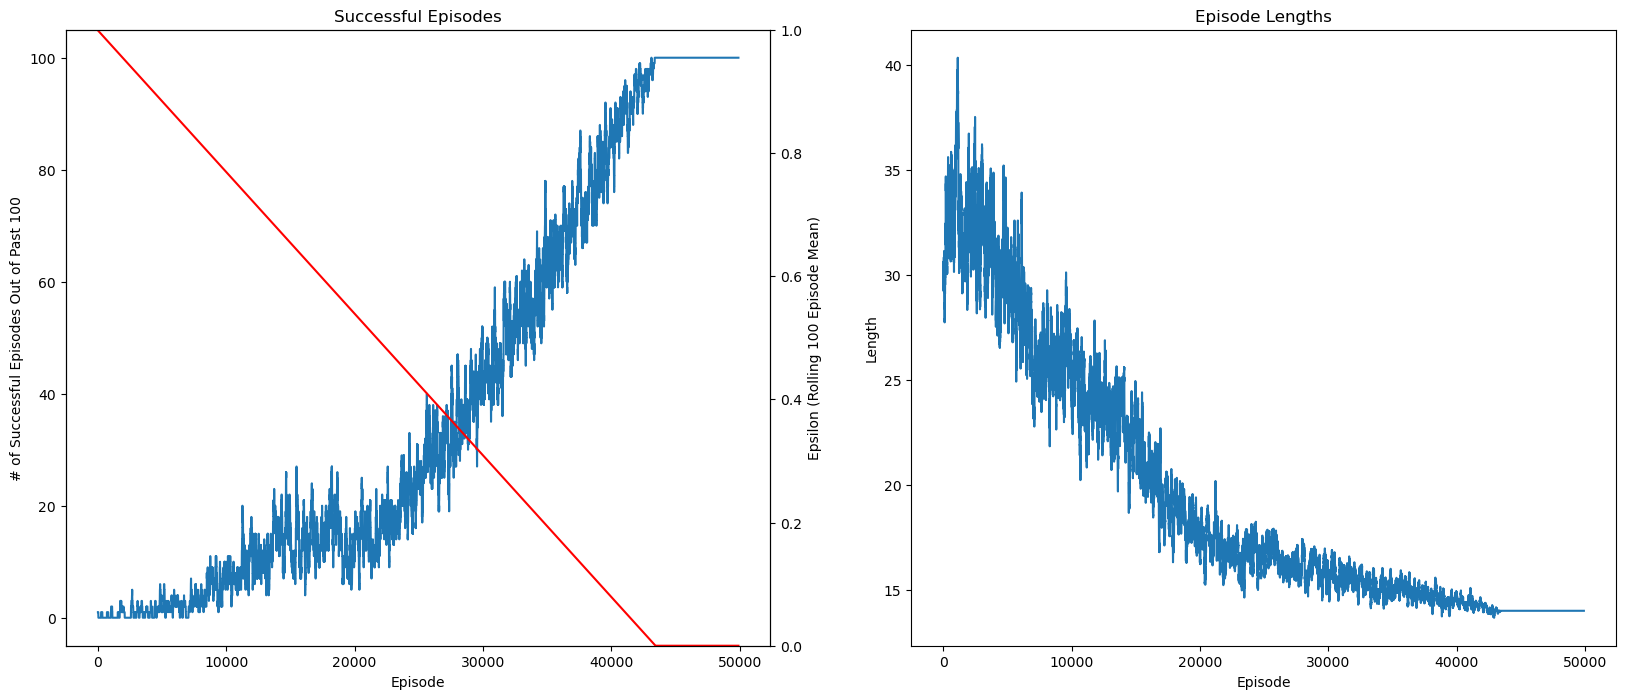

In [62]:
# render="Human" to visualize
# Slippery = False
run_episodes(50000, epsilon_change=0.000023, slippery=False, discount_factor=0.5)

Ran using the following settings:
Episodes: 50000
Learning Rate: 0.05
Discount Factor: 0.75
Initial Epsilon: 1
Epsilon Decay (per episode): 2.3e-05
Slippery: False

Episode 4999  , Epsilon: 0.885  | Completions so Far: 41  | Success Rate so Far: 0.8 %
Episode 9999  , Epsilon: 0.77  | Completions so Far: 235  | Success Rate so Far: 2.4 %
Episode 14999  , Epsilon: 0.655  | Completions so Far: 697  | Success Rate so Far: 4.6 %
Episode 19999  , Epsilon: 0.54  | Completions so Far: 1339  | Success Rate so Far: 6.7 %
Episode 24999  , Epsilon: 0.425  | Completions so Far: 2328  | Success Rate so Far: 9.3 %
Episode 29999  , Epsilon: 0.31  | Completions so Far: 4022  | Success Rate so Far: 13.4 %
Episode 34999  , Epsilon: 0.195  | Completions so Far: 6552  | Success Rate so Far: 18.7 %
Episode 39999  , Epsilon: 0.08  | Completions so Far: 10189  | Success Rate so Far: 25.5 %
Episode 44999  , Epsilon: 0  | Completions so Far: 14908  | Success Rate so Far: 33.1 %
Episode 49999  , Epsilon: 0  | Co

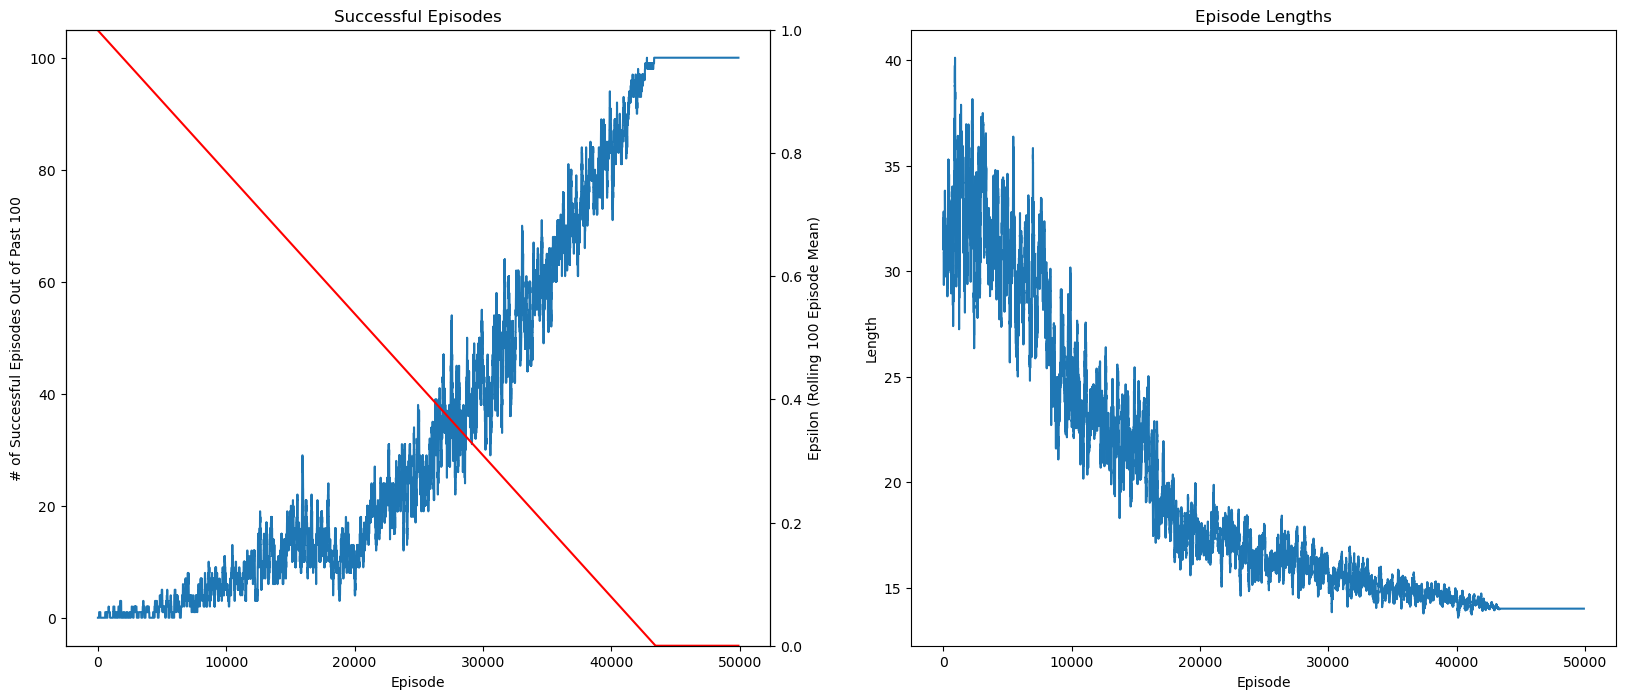

In [63]:
# render="Human" to visualize
# Slippery = False
run_episodes(50000, epsilon_change=0.000023, slippery=False, discount_factor=0.75)

Ran using the following settings:
Episodes: 50000
Learning Rate: 0.05
Discount Factor: 0.9
Initial Epsilon: 1
Epsilon Decay (per episode): 2.3e-05
Slippery: False

Episode 4999  , Epsilon: 0.885  | Completions so Far: 45  | Success Rate so Far: 0.8999999999999999 %
Episode 9999  , Epsilon: 0.77  | Completions so Far: 224  | Success Rate so Far: 2.1999999999999997 %
Episode 14999  , Epsilon: 0.655  | Completions so Far: 684  | Success Rate so Far: 4.6 %
Episode 19999  , Epsilon: 0.54  | Completions so Far: 1441  | Success Rate so Far: 7.199999999999999 %
Episode 24999  , Epsilon: 0.425  | Completions so Far: 2366  | Success Rate so Far: 9.5 %
Episode 29999  , Epsilon: 0.31  | Completions so Far: 4034  | Success Rate so Far: 13.4 %
Episode 34999  , Epsilon: 0.195  | Completions so Far: 6570  | Success Rate so Far: 18.8 %
Episode 39999  , Epsilon: 0.08  | Completions so Far: 10199  | Success Rate so Far: 25.5 %
Episode 44999  , Epsilon: 0  | Completions so Far: 14885  | Success Rate so Fa

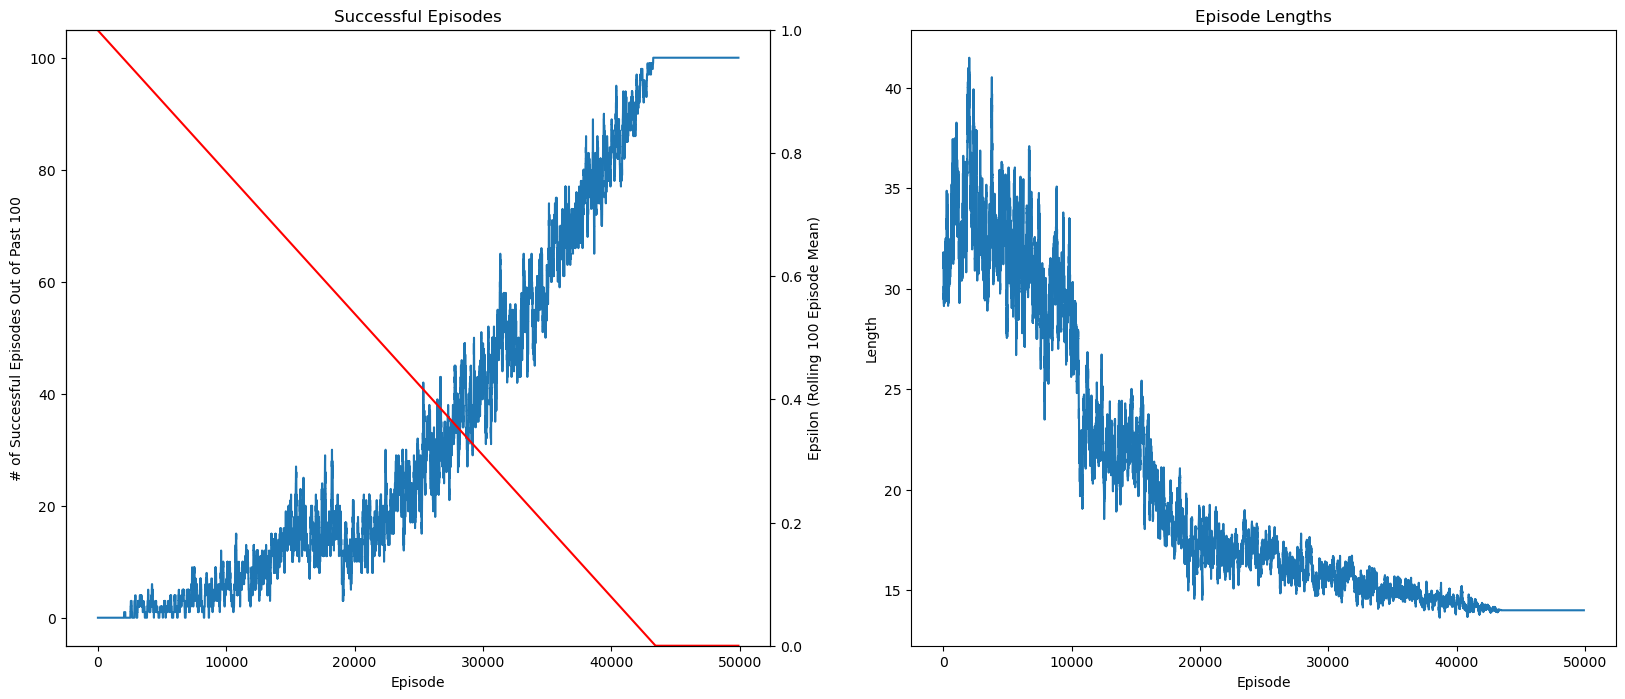

In [64]:
# render="Human" to visualize
# Slippery = False
run_episodes(50000, epsilon_change=0.000023, slippery=False, discount_factor=0.9)

Ran using the following settings:
Episodes: 50000
Learning Rate: 0.05
Discount Factor: 0.95
Initial Epsilon: 1
Epsilon Decay (per episode): 2.3e-05
Slippery: False

Episode 4999  , Epsilon: 0.885  | Completions so Far: 33  | Success Rate so Far: 0.7000000000000001 %
Episode 9999  , Epsilon: 0.77  | Completions so Far: 255  | Success Rate so Far: 2.6 %
Episode 14999  , Epsilon: 0.655  | Completions so Far: 889  | Success Rate so Far: 5.8999999999999995 %
Episode 19999  , Epsilon: 0.54  | Completions so Far: 1627  | Success Rate so Far: 8.1 %
Episode 24999  , Epsilon: 0.425  | Completions so Far: 2565  | Success Rate so Far: 10.299999999999999 %
Episode 29999  , Epsilon: 0.31  | Completions so Far: 4128  | Success Rate so Far: 13.8 %
Episode 34999  , Epsilon: 0.195  | Completions so Far: 6697  | Success Rate so Far: 19.1 %
Episode 39999  , Epsilon: 0.08  | Completions so Far: 10350  | Success Rate so Far: 25.900000000000002 %
Episode 44999  , Epsilon: 0  | Completions so Far: 15066  | Su

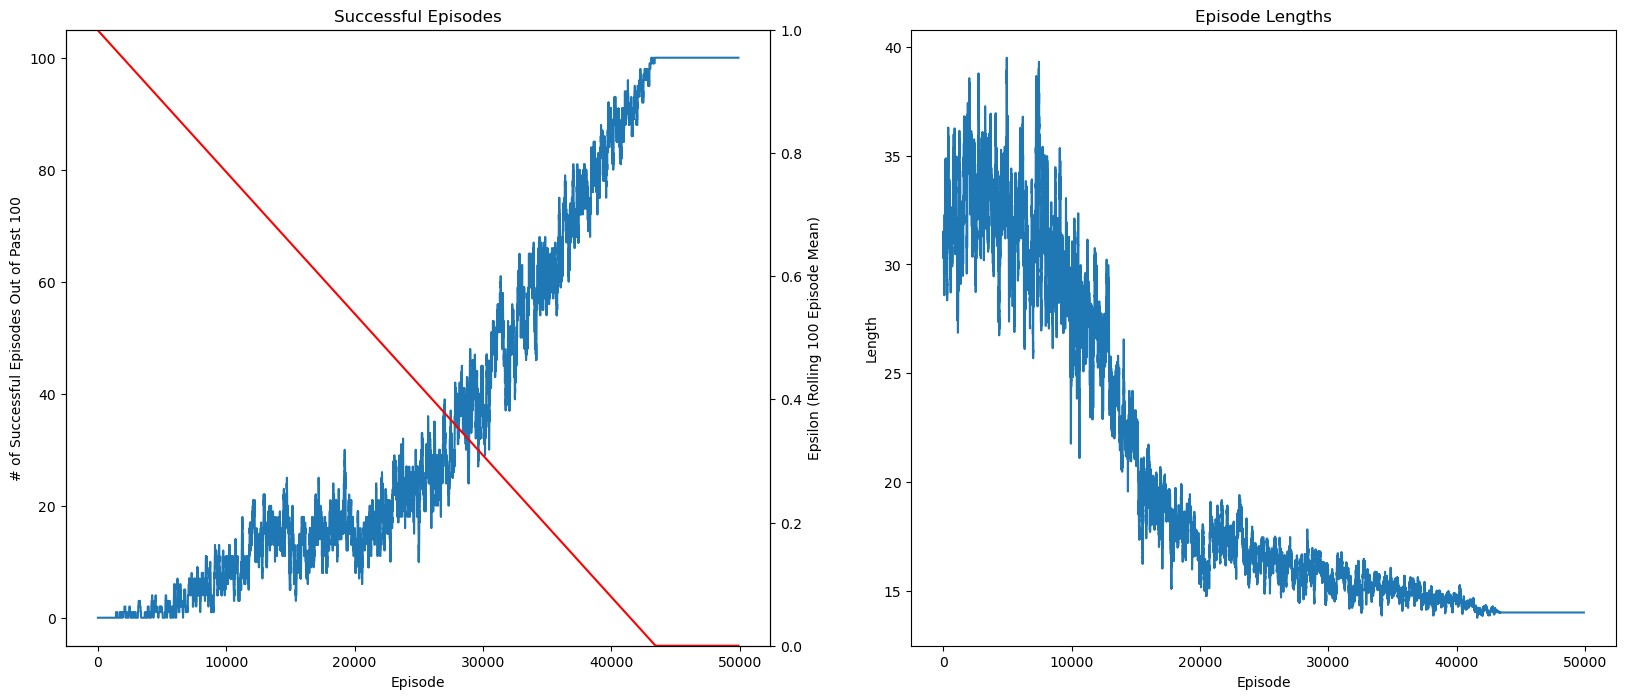

In [65]:
# render="Human" to visualize
# Slippery = False
run_episodes(50000, epsilon_change=0.000023, slippery=False, discount_factor=0.95)

Ran using the following settings:
Episodes: 50000
Learning Rate: 0.05
Discount Factor: 0.99
Initial Epsilon: 1
Epsilon Decay (per episode): 2.3e-05
Slippery: False

Episode 4999  , Epsilon: 0.885  | Completions so Far: 52  | Success Rate so Far: 1.0 %
Episode 9999  , Epsilon: 0.77  | Completions so Far: 372  | Success Rate so Far: 3.6999999999999997 %
Episode 14999  , Epsilon: 0.655  | Completions so Far: 985  | Success Rate so Far: 6.6000000000000005 %
Episode 19999  , Epsilon: 0.54  | Completions so Far: 1524  | Success Rate so Far: 7.6 %
Episode 24999  , Epsilon: 0.425  | Completions so Far: 2406  | Success Rate so Far: 9.6 %
Episode 29999  , Epsilon: 0.31  | Completions so Far: 3937  | Success Rate so Far: 13.100000000000001 %
Episode 34999  , Epsilon: 0.195  | Completions so Far: 6429  | Success Rate so Far: 18.4 %
Episode 39999  , Epsilon: 0.08  | Completions so Far: 10035  | Success Rate so Far: 25.1 %
Episode 44999  , Epsilon: 0  | Completions so Far: 14732  | Success Rate so F

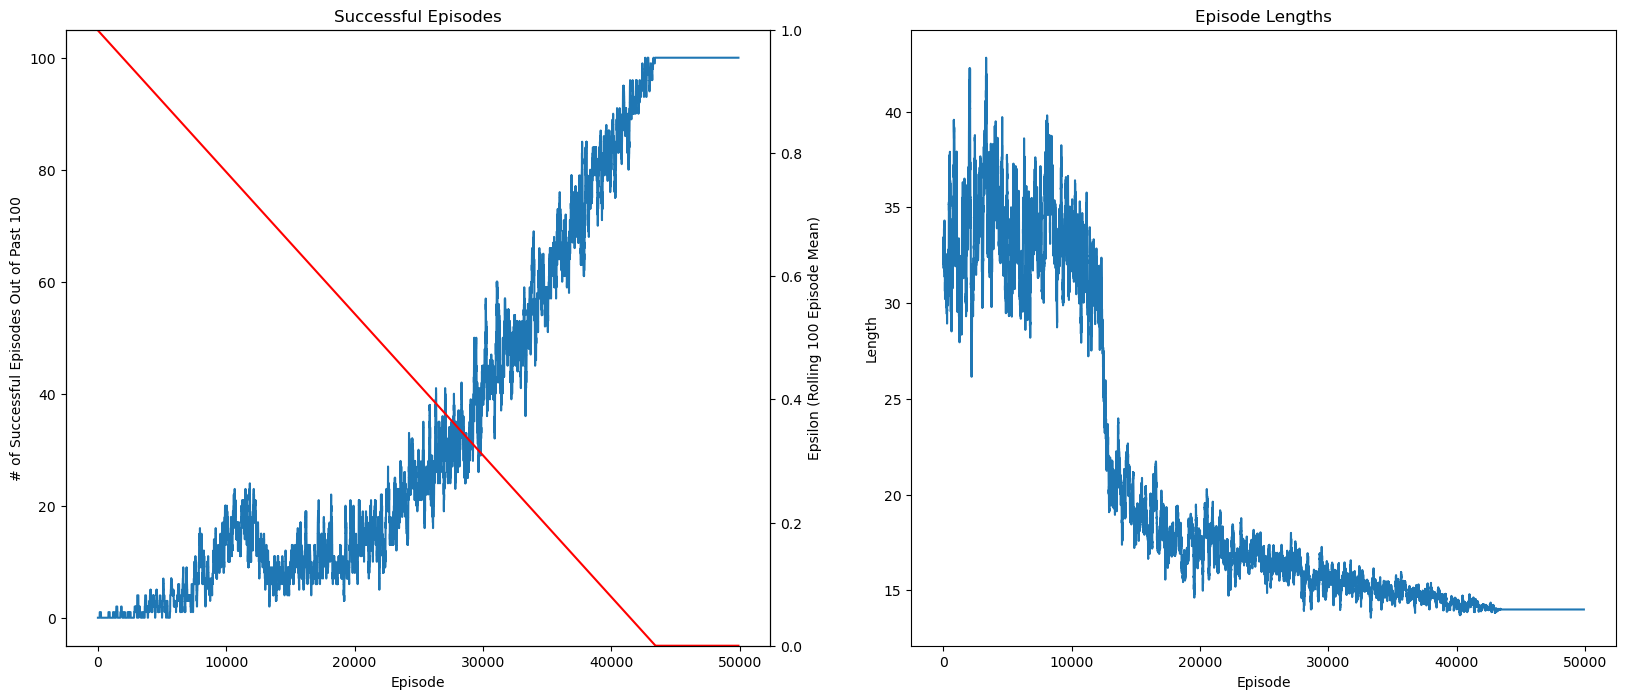

In [66]:
# render="Human" to visualize
# Slippery = False
run_episodes(50000, epsilon_change=0.000023, slippery=False, discount_factor=0.99)

Ran using the following settings:
Episodes: 50000
Learning Rate: 0.05
Discount Factor: 0.9999
Initial Epsilon: 1
Epsilon Decay (per episode): 2.3e-05
Slippery: False

Episode 4999  , Epsilon: 0.885  | Completions so Far: 29  | Success Rate so Far: 0.6 %
Episode 9999  , Epsilon: 0.77  | Completions so Far: 213  | Success Rate so Far: 2.1 %
Episode 14999  , Epsilon: 0.655  | Completions so Far: 844  | Success Rate so Far: 5.6000000000000005 %
Episode 19999  , Epsilon: 0.54  | Completions so Far: 1610  | Success Rate so Far: 8.1 %
Episode 24999  , Epsilon: 0.425  | Completions so Far: 2865  | Success Rate so Far: 11.5 %
Episode 29999  , Epsilon: 0.31  | Completions so Far: 4861  | Success Rate so Far: 16.2 %
Episode 34999  , Epsilon: 0.195  | Completions so Far: 7721  | Success Rate so Far: 22.1 %
Episode 39999  , Epsilon: 0.08  | Completions so Far: 11501  | Success Rate so Far: 28.799999999999997 %
Episode 44999  , Epsilon: 0  | Completions so Far: 16301  | Success Rate so Far: 36.19999

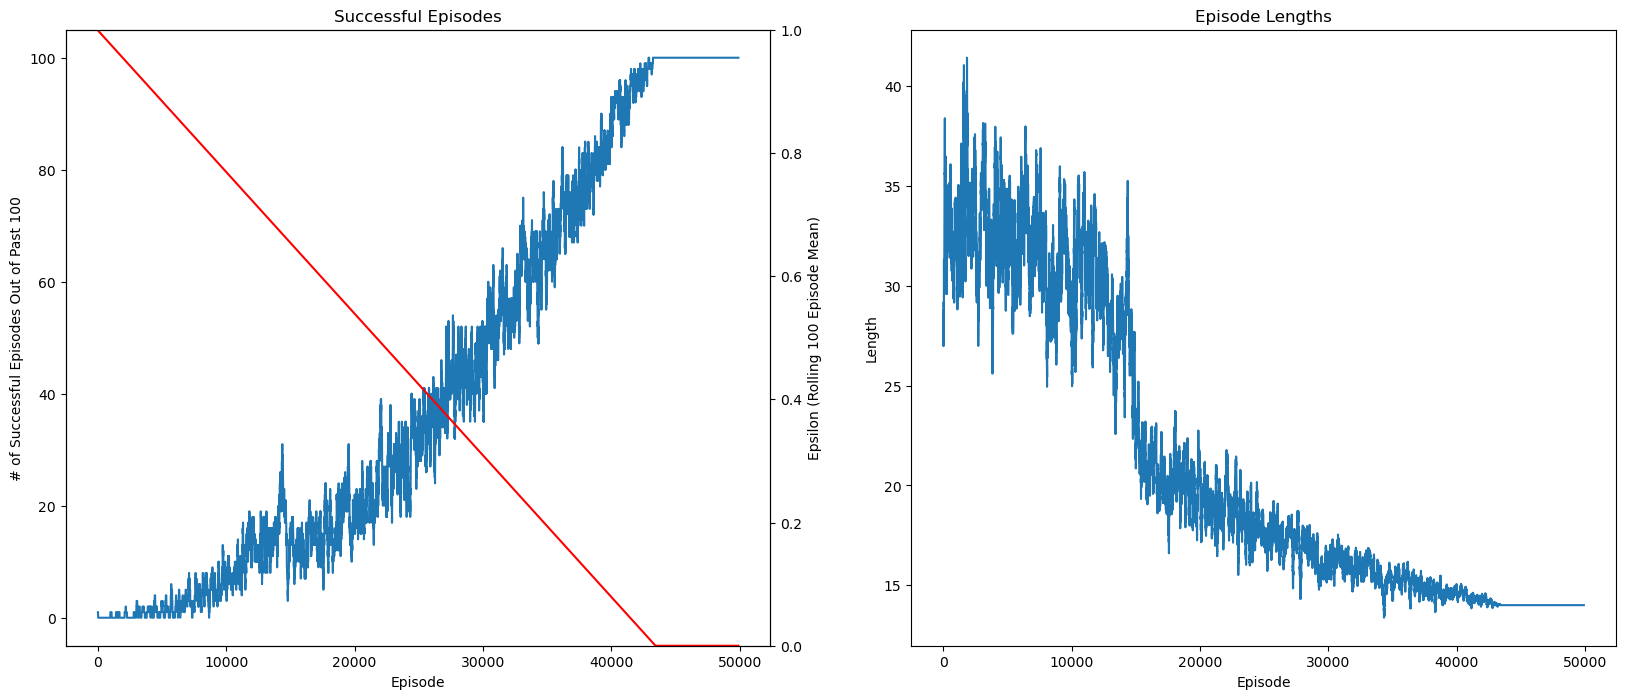

In [67]:
# render="Human" to visualize
# Slippery = False
run_episodes(50000, epsilon_change=0.000023, slippery=False, discount_factor=0.9999)

In [2]:
import gymnasium as gym
import numpy as np
import time
import math
from matplotlib import pyplot as plt
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

In [5]:
# render="Human" to visualize
# Slippery = False
env = gym.make("FrozenLake-v1", desc=generate_random_map(size=12), is_slippery=True)
state, info = env.reset()
print("state:", state)
print("info:", info)
print("")
action = env.action_space.sample()
new_state, reward, terminated, truncated, info = env.step(action)
print("new_state:", new_state)
print("reward:", reward)
print("terminated:", terminated)
print("truncated:", truncated)
print("info:", info)
print("")
q = np.zeros((env.observation_space.n, env.action_space.n)) # q-value storage
print(q)


env.close()

state: 0
info: {'prob': 1}

new_state: 12
reward: 0.0
terminated: True
truncated: False
info: {'prob': 0.3333333333333333}

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0

Research Resources:
- AI (CSCI 4610U) Lectures
- ML2 (CSCI 4052U) Lectures
- https://www.youtube.com/watch?v=ZhoIgo3qqLU - FrozenLake Gymnasium
- https://gymnasium.farama.org/environments/toy_text/frozen_lake/
